# **ASSIGNMENT 2** - 36103 Statistical Thinking for Data Science - Spring 2025

## 1. Setup and Load datasets

### 1.1. Import Packages

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)

### 1.2 Load Datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Problem Formulation

**Context:**
The data consists of 30-minute increments of electricity demand and price for Victoria, New South Wales, and Queensland, Australia, spanning from 2018 to mid-2023. This data is made publicly available by the Australian Energy Market Operator (AEMO) under their Copyright Permission.

**Problem Statement:**
To analyze the provided AEMO electricity demand and price data for Victoria, NSW, and Queensland to identify patterns, trends, and potential relationships between demand and price over time and across different regions. This analysis aims to understand the dynamics of the Australian electricity market based on historical data.

**Research Questions:**
* How has electricity demand changed over time in each of the three regions (Victoria, NSW, and Queensland) between 2018 and mid-2023?
* What are the trends in electricity prices in each region during the same period?
* Is there a correlation between electricity demand and price in each region?
* Are there seasonal or daily patterns in electricity demand and price?
* How do the electricity demand and price patterns compare across Victoria, NSW, and Queensland?

**Hypotheses:**
* Electricity demand will show an increasing trend over the years in all three regions.
* Electricity prices will exhibit volatility and may be influenced by demand fluctuations.
* There will be a positive correlation between electricity demand and price, especially during peak demand periods.
* Electricity demand and price will show distinct seasonal patterns (e.g., higher demand in summer and winter) and daily patterns (e.g., peak demand in the morning and evening).
* There will be regional differences in the magnitude and patterns of electricity demand and price due to factors like population density, industrial activity, and climate.

## 3. Data Preprocessing

### 3.1 Handling Data Types

In [4]:
# Convert SETTLEMENTDATE from object to datetime
df['SETTLEMENTDATE'] = pd.to_datetime(
    df['SETTLEMENTDATE'],
    format='%Y/%m/%d %H:%M:%S',   # match your current format
    errors='coerce'               # invalid parsing → NaT
)

# Check the result
print(df.dtypes)
print(df['SETTLEMENTDATE'].head())

REGION                    object
SETTLEMENTDATE    datetime64[ns]
TOTALDEMAND              float64
RRP                      float64
PERIODTYPE                object
dtype: object
0   2025-01-01 00:05:00
1   2025-01-01 00:10:00
2   2025-01-01 00:15:00
3   2025-01-01 00:20:00
4   2025-01-01 00:25:00
Name: SETTLEMENTDATE, dtype: datetime64[ns]


### 3.2 Handling Missing Values

In [5]:
# Check for missing values in the combined dataframe
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
REGION            0
SETTLEMENTDATE    0
TOTALDEMAND       0
RRP               0
PERIODTYPE        0
dtype: int64


### 3.3 Feature Engineering - Extracting Time-Based Features

In [6]:
# Extract time-based features
df['Year'] = df['SETTLEMENTDATE'].dt.year
df['Month'] = df['SETTLEMENTDATE'].dt.month
df['Day'] = df['SETTLEMENTDATE'].dt.day
df['Hour'] = df['SETTLEMENTDATE'].dt.hour
df['Dayofweek'] = df['SETTLEMENTDATE'].dt.dayofweek # Monday=0, Sunday=6

# Display the first few rows with the new columns
display(df.head())

REGION      SETTLEMENTDATE  TOTALDEMAND     RRP PERIODTYPE  Year  Month  \
0   TAS1 2025-01-01 00:05:00       989.78  125.18      TRADE  2025      1   
1   TAS1 2025-01-01 00:10:00       991.04  120.28      TRADE  2025      1   
2   TAS1 2025-01-01 00:15:00       991.23  129.97      TRADE  2025      1   
3   TAS1 2025-01-01 00:20:00       985.66  118.28      TRADE  2025      1   
4   TAS1 2025-01-01 00:25:00       970.26  118.28      TRADE  2025      1   

   Day  Hour  Dayofweek  
0    1     0          2  
1    1     0          2  
2    1     0          2  
3    1     0          2  
4    1     0          2

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2379696 entries, 0 to 2379695
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   REGION          object        
 1   SETTLEMENTDATE  datetime64[ns]
 2   TOTALDEMAND     float64       
 3   RRP             float64       
 4   PERIODTYPE      object        
 5   Year            int32         
 6   Month           int32         
 7   Day             int32         
 8   Hour            int32         
 9   Dayofweek       int32         
dtypes: datetime64[ns](1), float64(2), int32(5), object(2)
memory usage: 136.2+ MB


## 4. Exploratory Data Analysis (EDA)

### 4.1 Explore Target Variable

In [8]:
# Summary of target variables
print(df['TOTALDEMAND'].describe())
print("-"*50)
print(df['RRP'].describe())

count    2.379696e+06
mean     4.180176e+03
std      2.746156e+03
min     -2.318200e+02
25%      1.268970e+03
50%      4.510375e+03
75%      6.411763e+03
max      1.376396e+04
Name: TOTALDEMAND, dtype: float64
--------------------------------------------------
count    2.379696e+06
mean     1.048061e+02
std      3.899606e+02
min     -1.000000e+03
25%      3.460000e+01
50%      7.672000e+01
75%      1.280200e+02
max      1.750000e+04
Name: RRP, dtype: float64


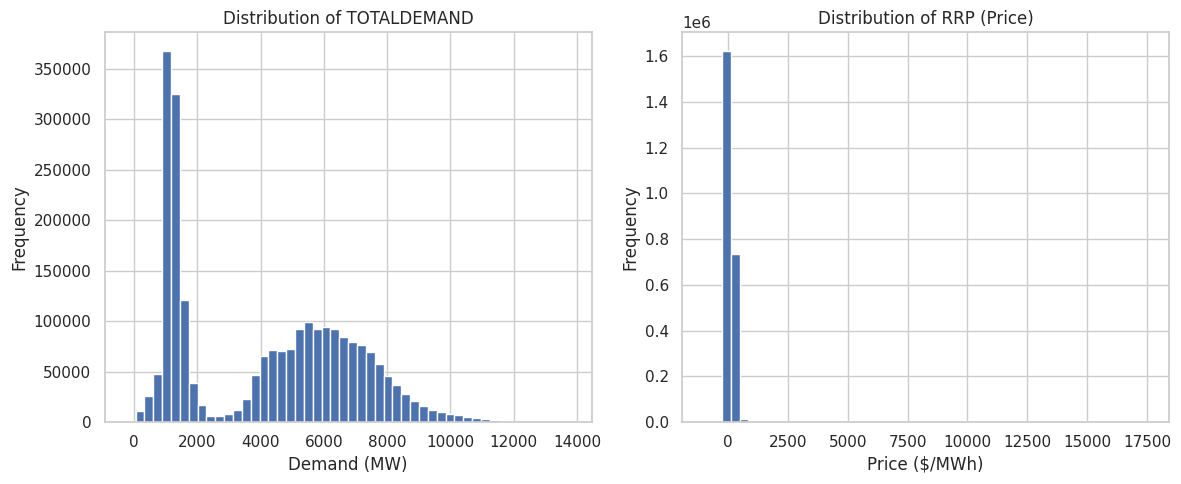

In [9]:
# Target Distribution Plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df['TOTALDEMAND'].hist(bins=50)
plt.title("Distribution of TOTALDEMAND")
plt.xlabel("Demand (MW)")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
df['RRP'].hist(bins=50)
plt.title("Distribution of RRP (Price)")
plt.xlabel("Price ($/MWh)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

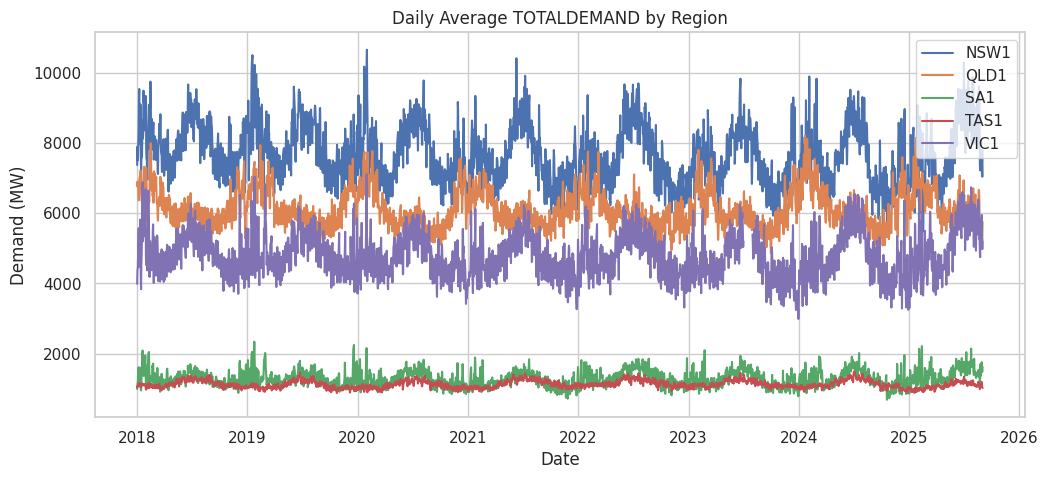

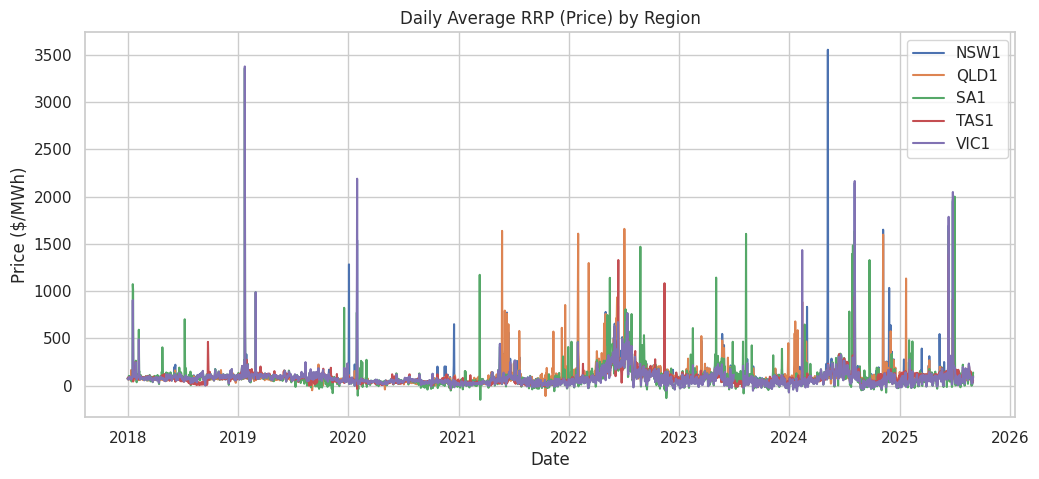

In [10]:
# Target Time-Series Patterns
# Resample to daily averages
daily_demand = df.groupby('REGION').resample('D', on='SETTLEMENTDATE')['TOTALDEMAND'].mean().reset_index()
daily_price = df.groupby('REGION').resample('D', on='SETTLEMENTDATE')['RRP'].mean().reset_index()

# Plot demand trend
plt.figure(figsize=(12,5))
for region in daily_demand['REGION'].unique():
    subset = daily_demand[daily_demand['REGION'] == region]
    plt.plot(subset['SETTLEMENTDATE'], subset['TOTALDEMAND'], label=region)

plt.title("Daily Average TOTALDEMAND by Region")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.legend()
plt.show()

# Plot price trend
plt.figure(figsize=(12,5))
for region in daily_price['REGION'].unique():
    subset = daily_price[daily_price['REGION'] == region]
    plt.plot(subset['SETTLEMENTDATE'], subset['RRP'], label=region)

plt.title("Daily Average RRP (Price) by Region")
plt.xlabel("Date")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.show()

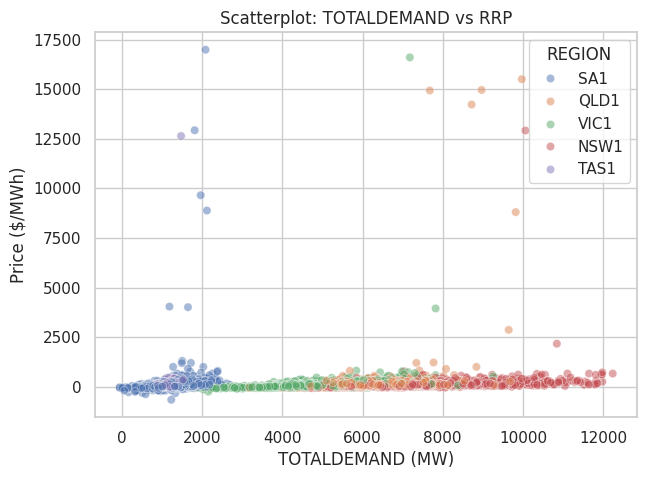

In [11]:
# Correlation Between Demand & Price
plt.figure(figsize=(7,5))
sns.scatterplot(data=df.sample(10000), x='TOTALDEMAND', y='RRP', hue='REGION', alpha=0.5)
plt.title("Scatterplot: TOTALDEMAND vs RRP")
plt.xlabel("TOTALDEMAND (MW)")
plt.ylabel("Price ($/MWh)")
plt.show()

**Insights** from **Target Variable** Exploration

1. **Total Demand** (`TOTALDEMAND`)
*   **Range**: From ~2,000 MW to ~13,700 MW.
*   **Central Tendency**: **Mean** demand is ~6,158 MW, with a **median** of ~6,028 MW → distribution is fairly balanced but slightly **right-skewed** (long tail on higher demand).
*   **Variability**: **Standard deviation** ~1,564 MW → **strong daily and seasonal fluctuations**.
*   **Seasonality**: Clear **cyclical patterns** (**winter & summer peaks** due to heating/cooling, dips in mild seasons).
*   **Regional Differences**:
    *   **NSW** consistently shows the **highest demand**.
    *   **QLD** is moderate.
    *   **VIC** has the **lowest average demand**.

**Interpretation**: Demand is **stable but predictable** with **seasonal trends** → good candidate for **time-series forecasting**.

2. **Electricity Price** (`RRP`)
*   **Range**: **Extreme**, from `-$1,000` to `$15,500` /MWh.
*   **Central Tendency**: **Mean** `~$120`, **median** `~$84` → shows **heavy right skew** with many small values and rare but **huge spikes**.
*   **Variability**: **Standard deviation** `~$344`, much higher than the mean, reflecting **volatility**.
*   **Outliers/Spikes**:
    *   Prices occasionally drop **below zero** (**negative RRP**, happens in oversupply scenarios).
    *   **Huge spikes** (`>$3,000`) appear irregularly, often linked to **supply shortages or demand shocks**.
*   **Regional Trends**:
    *   **VIC** and **QLD** show several **extreme price spikes**.
    *   **NSW** less frequent but still **volatile**.

**Interpretation**: Price is **highly volatile** with **heavy-tailed distribution** → difficult to model directly with regression; better suited for **classification** (spike vs. normal) or **anomaly detection**.

3. **Demand vs Price Relationship**

*   **Scatterplot** shows a **non-linear pattern**:
    *   At low to medium demand, price remains relatively stable.
    *   At very high demand, price becomes more volatile, with **sharp upward spikes**.
  
*   However, **correlation is not perfect** → suggests **other external drivers** (fuel mix, outages, weather) strongly influence price.

**Interpretation**: Demand alone cannot fully explain price variation → if the team focuses on **price prediction**, **external features** need to be considered.

**Overall Takeaways**

- **TOTALDEMAND** is well-behaved (good candidate for **forecasting task**).
- **RRP** is volatile and skewed (better for **classification** or **anomaly detection** rather than raw regression).
- Clear **seasonal and regional differences** exist >> strong case for adding **time features** (hour, weekday, month, season) and regional encoding.

### 4.2 Explore categorical features

In [12]:
# Unique values
print("Unique values in REGION:", df['REGION'].unique())
print("Unique values in PERIODTYPE:", df['PERIODTYPE'].unique())
print("Unique values in Dayofweek:", df['Dayofweek'].unique())

# Counts by category
print(df['REGION'].value_counts())
print(df['Dayofweek'].value_counts())

Unique values in REGION: ['TAS1' 'QLD1' 'NSW1' 'SA1' 'VIC1']
Unique values in PERIODTYPE: ['TRADE']
Unique values in Dayofweek: [2 3 4 5 6 0 1]
REGION
TAS1    477840
QLD1    477840
SA1     477840
NSW1    476976
VIC1    469200
Name: count, dtype: int64
Dayofweek
5    340847
6    340561
4    340560
1    339647
2    339361
3    339360
0    339360
Name: count, dtype: int64


### 4.3 Explore numerical features

In [13]:
# Correlation matrix
num_cols = ['TOTALDEMAND','RRP','Year','Month','Day','Hour','Dayofweek']
print(df[num_cols].corr())

# Summary stats
print(df[num_cols].describe())

             TOTALDEMAND       RRP      Year     Month       Day  \
TOTALDEMAND     1.000000  0.082106  0.006048 -0.039068 -0.002156   
RRP             0.082106  1.000000  0.012058 -0.018279 -0.008495   
Year            0.006048  0.012058  1.000000 -0.169527 -0.000676   
Month          -0.039068 -0.018279 -0.169527  1.000000  0.011036   
Day            -0.002156 -0.008495 -0.000676  0.011036  1.000000   
Hour            0.113522  0.051257 -0.000014 -0.000008 -0.000002   
Dayofweek      -0.045532 -0.033851  0.001172  0.004484 -0.002111   

                     Hour     Dayofweek  
TOTALDEMAND  1.135219e-01 -4.553209e-02  
RRP          5.125734e-02 -3.385064e-02  
Year        -1.386363e-05  1.172262e-03  
Month       -7.672597e-06  4.483679e-03  
Day         -2.221185e-06 -2.110542e-03  
Hour         1.000000e+00 -6.980375e-07  
Dayofweek   -6.980375e-07  1.000000e+00  
        TOTALDEMAND           RRP          Year         Month           Day  \
count  2.379696e+06  2.379696e+06  2.379

<Axes: title={'center': 'Average Demand by Day of Week'}, xlabel='Dayofweek'>

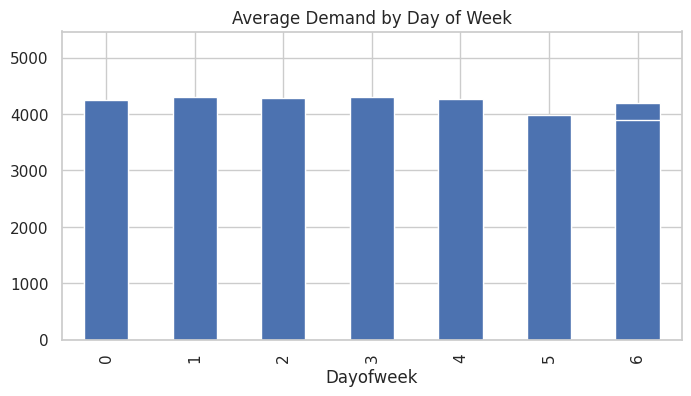

In [14]:
# Average demand by region
df.groupby('REGION')['TOTALDEMAND'].mean()

# Average demand by hour of day
df.groupby('Hour')['TOTALDEMAND'].mean().plot(kind='bar', figsize=(12,4), title="Average Demand by Hour")

# Average demand by day of week
df.groupby('Dayofweek')['TOTALDEMAND'].mean().plot(kind='bar', figsize=(8,4), title="Average Demand by Day of Week")

Text(0.5, 1.0, 'Distribution of Demand by Day of Week')

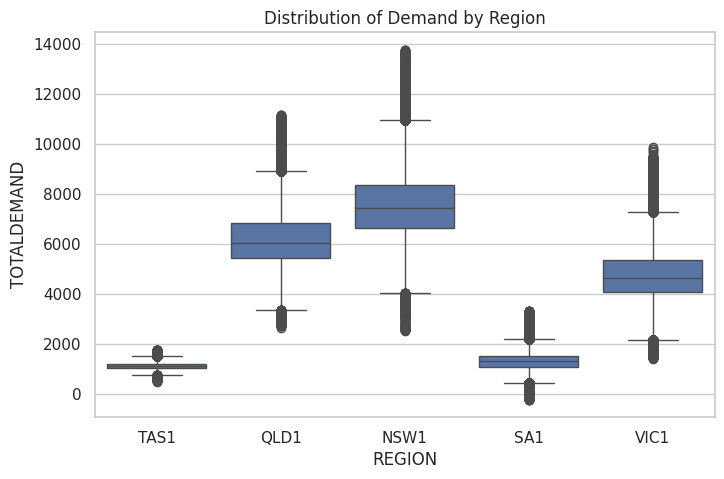

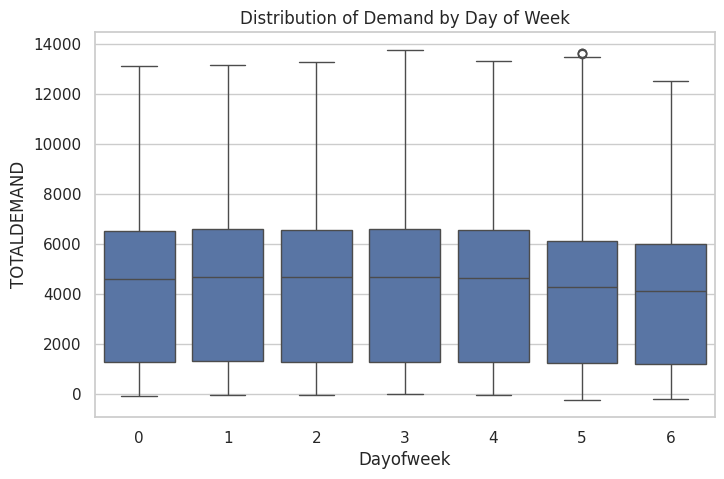

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(x='REGION', y='TOTALDEMAND', data=df)
plt.title("Distribution of Demand by Region")

plt.figure(figsize=(8,5))
sns.boxplot(x='Dayofweek', y='TOTALDEMAND', data=df)
plt.title("Distribution of Demand by Day of Week")

## 5. Data Preprocessing

In [16]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# -----------------------------------
# 5.0 Helper: build features for a given horizon (in half-hours)
# -----------------------------------
def make_horizon_dataset(df_raw: pd.DataFrame, horizon_hh: int = 48,
                         use_rrp_as_feature: bool = True) -> dict:
    """
    Build a modeling dataset for a chosen forecast horizon (in half-hours).
    - horizon_hh=48  -> day-ahead
    - horizon_hh=336 -> week-ahead

    We intentionally avoid ultra-short lags (e.g., lag_1) to reflect realistic planning.
    We use longer lags aligned with daily/weekly seasonality and rolling stats on past values only.
    """
    df = df_raw.copy()

    # --- Ensure datetime + basic calendar fields ---
    if not np.issubdtype(df["SETTLEMENTDATE"].dtype, np.datetime64):
        df["SETTLEMENTDATE"] = pd.to_datetime(df["SETTLEMENTDATE"], errors="coerce")

    df["Year"]      = df["SETTLEMENTDATE"].dt.year.astype("int32")
    df["Month"]     = df["SETTLEMENTDATE"].dt.month.astype("int32")
    df["Day"]       = df["SETTLEMENTDATE"].dt.day.astype("int32")
    df["Hour"]      = df["SETTLEMENTDATE"].dt.hour.astype("int32")
    df["Dayofweek"] = df["SETTLEMENTDATE"].dt.dayofweek.astype("int32")

    # --- Target at horizon_hh steps ahead ---
    # Predict TOTALDEMAND at t + horizon_hh
    df[f"TARGET_{horizon_hh}"] = (
        df.groupby("REGION")["TOTALDEMAND"].shift(-horizon_hh)
    )

    # --- Feature Engineering (only past info; no look-ahead) ---
    # Choose longer lags (daily/bi-daily/weekly) to reflect realistic availability
    long_lags = sorted(set([
        48,                         # 1 day back
        96, 144,                    # 2, 3 days back
        336,                        # 1 week back
        672 if horizon_hh >= 336 else 0  # 2 weeks back if doing week-ahead
    ]) - {0})

    for lg in long_lags:
        df[f"LAG_{lg}"] = df.groupby("REGION")["TOTALDEMAND"].shift(lg)

    # Rolling means/stds based on past values only (shift(1) before rolling)
    roll_windows = [48, 96, 336]  # 1-day, 2-day, 1-week windows
    for w in roll_windows:
        df[f"ROLL_MEAN_{w}"] = (
            df.groupby("REGION")["TOTALDEMAND"].shift(1).rolling(window=w, min_periods=w//2).mean()
        )
        df[f"ROLL_STD_{w}"] = (
            df.groupby("REGION")["TOTALDEMAND"].shift(1).rolling(window=w, min_periods=w//2).std()
        )

    # Cyclical encodings for hour-of-day and month-of-year
    df["HOUR_sin"]  = np.sin(2 * np.pi * df["Hour"]  / 24.0)
    df["HOUR_cos"]  = np.cos(2 * np.pi * df["Hour"]  / 24.0)
    df["MONTH_sin"] = np.sin(2 * np.pi * df["Month"] / 12.0)
    df["MONTH_cos"] = np.cos(2 * np.pi * df["Month"] / 12.0)

    # Optional exogenous: RRP as input (known at time t). It helps day-ahead/week-ahead sometimes.
    base_num = ["Year", "Month", "Hour"]
    if use_rrp_as_feature and "RRP" in df.columns:
        base_num += ["RRP"]

    # Compose numeric feature list
    lag_feats   = [f"LAG_{lg}" for lg in long_lags]
    roll_feats  = [f"ROLL_MEAN_{w}" for w in roll_windows] + [f"ROLL_STD_{w}" for w in roll_windows]
    cyc_feats   = ["HOUR_sin", "HOUR_cos", "MONTH_sin", "MONTH_cos"]
    num_features = base_num + lag_feats + roll_feats + cyc_feats

    # Categoricals
    cat_features = ["REGION", "Dayofweek"]

    # Drop rows with any NA from target or created features
    keep_cols = ["REGION", "SETTLEMENTDATE", f"TARGET_{horizon_hh}", "Dayofweek"] + num_features
    df_model = df[keep_cols].dropna().reset_index(drop=True)

    # Time-aware split: Train/Val = up to 2024-12-31; Test = from 2025-01-01
    cutoff = pd.Timestamp("2025-01-01")
    train_df = df_model[df_model["SETTLEMENTDATE"] < cutoff].copy()
    test_df  = df_model[df_model["SETTLEMENTDATE"] >= cutoff].copy()

    # X / y matrices
    X_train = train_df[cat_features + num_features]
    y_train = train_df[f"TARGET_{horizon_hh}"].values
    X_test  = test_df[cat_features + num_features]
    y_test  = test_df[f"TARGET_{horizon_hh}"].values

    # ColumnTransformer (fit on train only)
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
            ("num", StandardScaler(), num_features),
        ],
        remainder="drop"
    )
    preprocessor.fit(X_train)
    X_train_pre = preprocessor.transform(X_train)
    X_test_pre  = preprocessor.transform(X_test)

    # Names for later inspection
    cat_names = list(preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features))
    feature_names = cat_names + num_features

    info = {
        "horizon_hh": horizon_hh,
        "train_period": (train_df["SETTLEMENTDATE"].min(), train_df["SETTLEMENTDATE"].max()),
        "test_period":  (test_df["SETTLEMENTDATE"].min(),  test_df["SETTLEMENTDATE"].max()),
        "X_train_shape": X_train_pre.shape,
        "X_test_shape":  X_test_pre.shape,
    }

    return {
        "preprocessor": preprocessor,
        "feature_names": feature_names,
        "cat_features": cat_features,
        "num_features": num_features,
        "train_df": train_df,
        "test_df": test_df,
        "X_train_pre": X_train_pre,
        "X_test_pre": X_test_pre,
        "y_train": y_train,
        "y_test": y_test,
        "info": info
    }

# ============================
# Build BOTH datasets:
#   - Day-ahead (t+48)
#   - Week-ahead (t+336)
# Assumes your raw dataframe is `df` with at least:
# REGION, SETTLEMENTDATE (datetime or string), TOTALDEMAND, RRP (optional)
# ============================

day_ahead = make_horizon_dataset(df, horizon_hh=48,  use_rrp_as_feature=True)
week_ahead = make_horizon_dataset(df, horizon_hh=336, use_rrp_as_feature=True)

print("Day-ahead info:", day_ahead["info"])
print("Week-ahead info:", week_ahead["info"])

Day-ahead info: {'horizon_hh': 48, 'train_period': (Timestamp('2018-01-01 00:30:00'), Timestamp('2024-12-31 23:55:00')), 'test_period': (Timestamp('2025-01-01 00:00:00'), Timestamp('2025-09-01 00:00:00')), 'X_train_shape': (2028525, 30), 'X_test_shape': (349251, 30)}
Week-ahead info: {'horizon_hh': 336, 'train_period': (Timestamp('2018-01-01 00:30:00'), Timestamp('2024-12-31 23:55:00')), 'test_period': (Timestamp('2025-01-01 00:00:00'), Timestamp('2025-09-01 00:00:00')), 'X_train_shape': (2026077, 31), 'X_test_shape': (348579, 31)}



  DAY-AHEAD (T+48) FORECAST — Horizon = 48 half-hours
Train period: (Timestamp('2018-01-01 00:30:00'), Timestamp('2024-12-31 23:55:00'))
Test  period: (Timestamp('2025-01-01 00:00:00'), Timestamp('2025-09-01 00:00:00'))
X_train/X_test: (2028525, 30) (349251, 30)
        Naive-48 -> MAE: 997.39 | RMSE: 1399.77 | R²: 0.7604
          HistGB -> MAE: 280.06 | RMSE: 438.10 | R²: 0.9765

Per-region (Naive) metrics:
            MAE     RMSE    R2
REGION                        
NSW1    1624.73  2003.90 -0.77
QLD1    1398.21  1694.86 -1.37
SA1      535.89   645.82 -1.07
TAS1     134.83   162.76 -0.41
VIC1    1286.91  1564.72 -0.65

Per-region (HistGB) metrics:
           MAE    RMSE    R2
REGION                      
NSW1    436.26  617.24  0.83
QLD1    291.74  399.76  0.87
SA1     178.75  249.61  0.69
TAS1     73.77   89.44  0.58
VIC1    418.30  589.13  0.77


/tmp/ipython-input-1137291191.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dfm.groupby(region_col, group_keys=False).apply(
/tmp/ipython-input-1137291191.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dfm.groupby(region_col, group_keys=False).apply(


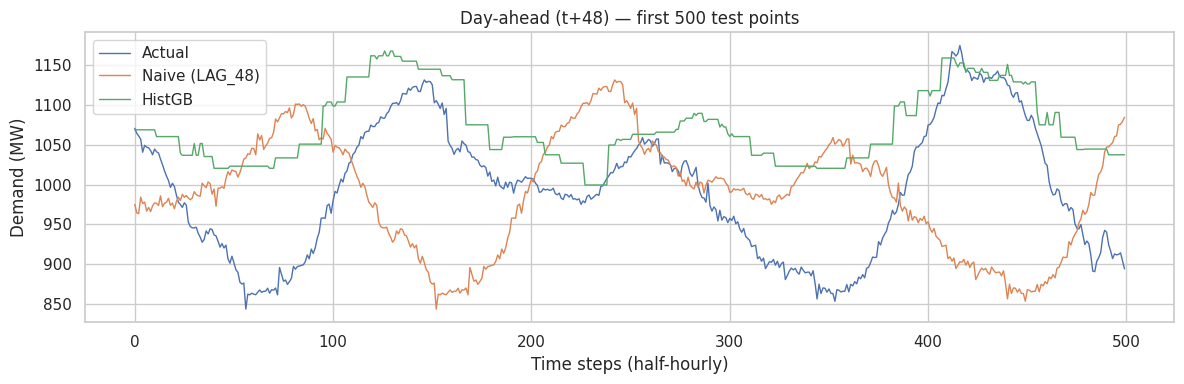

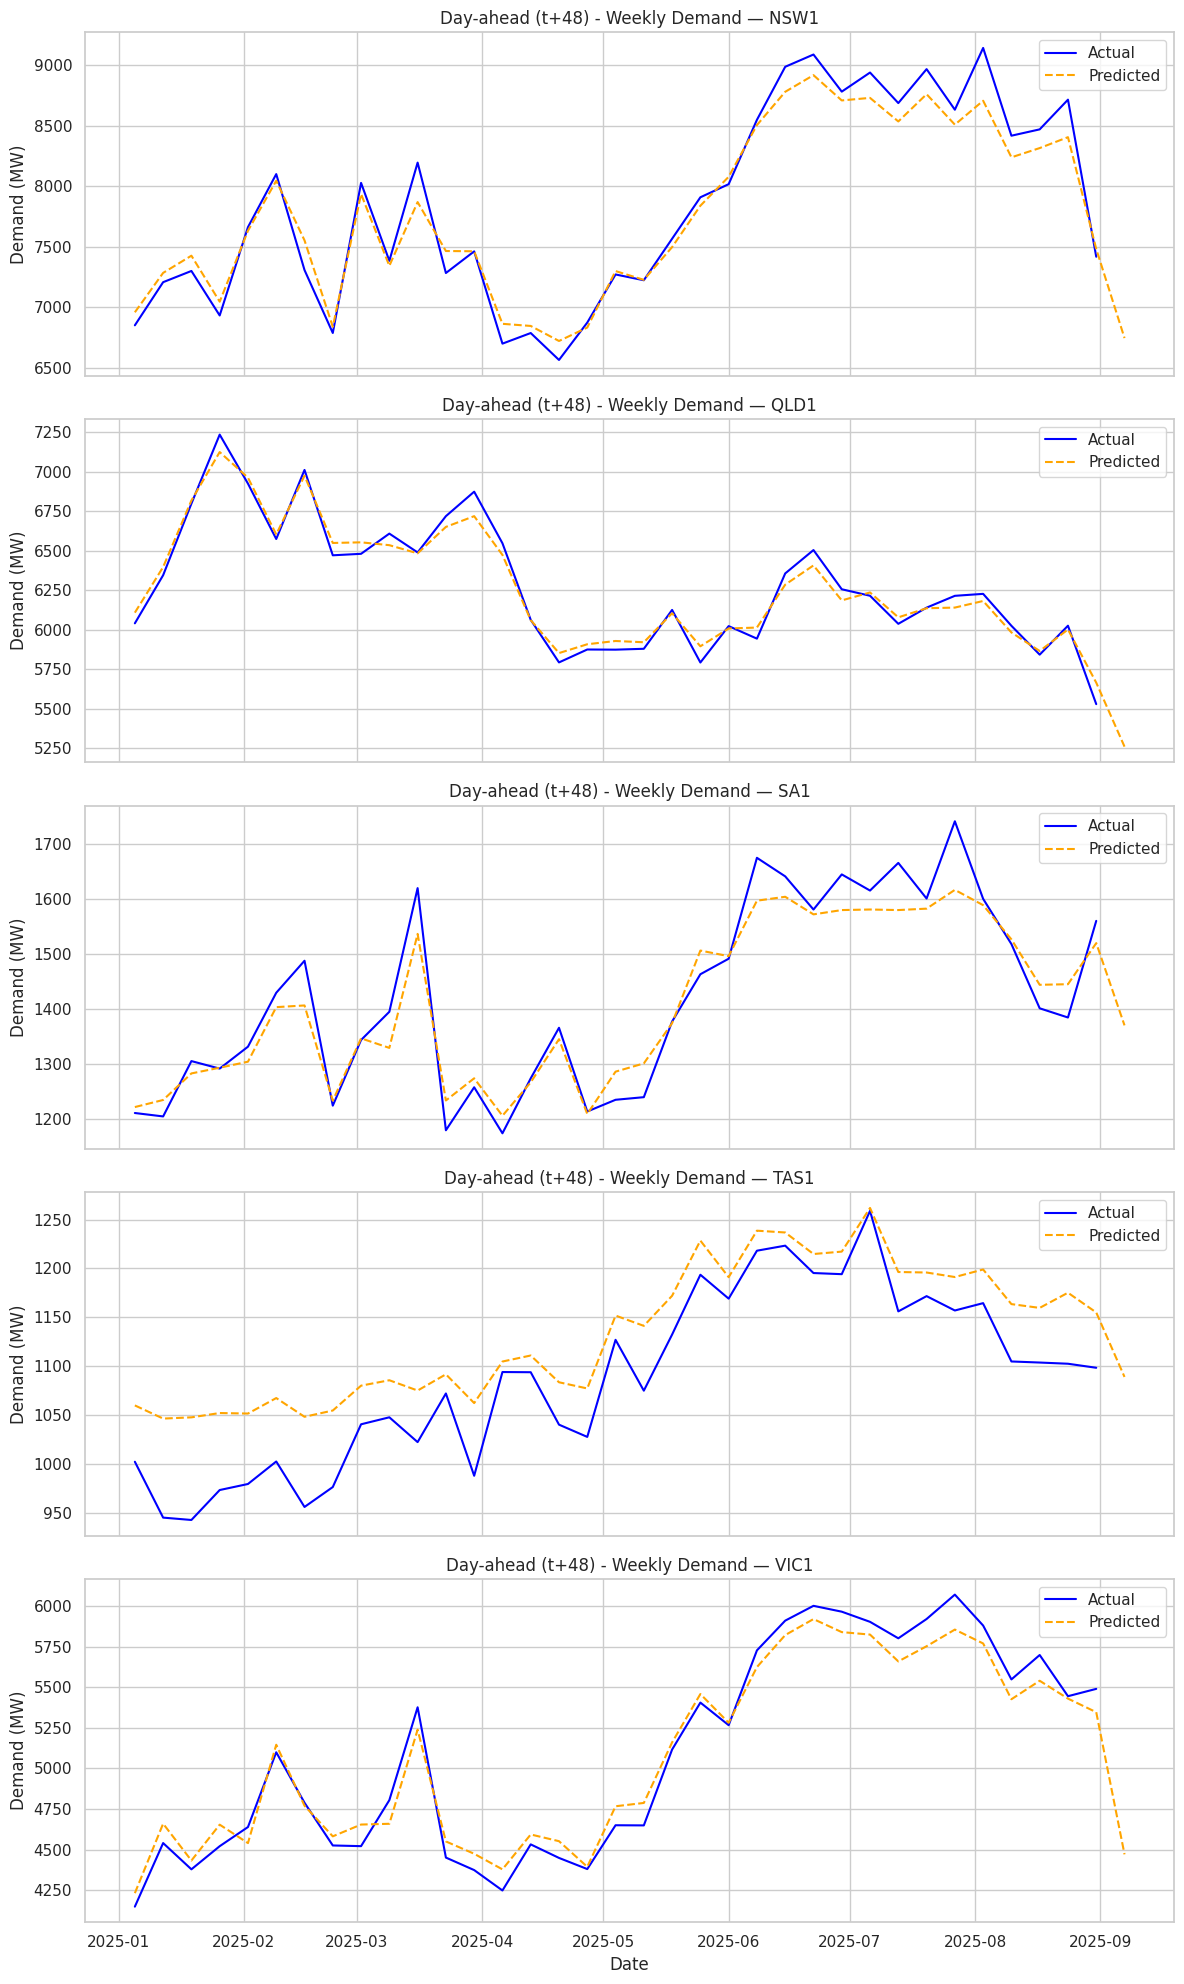

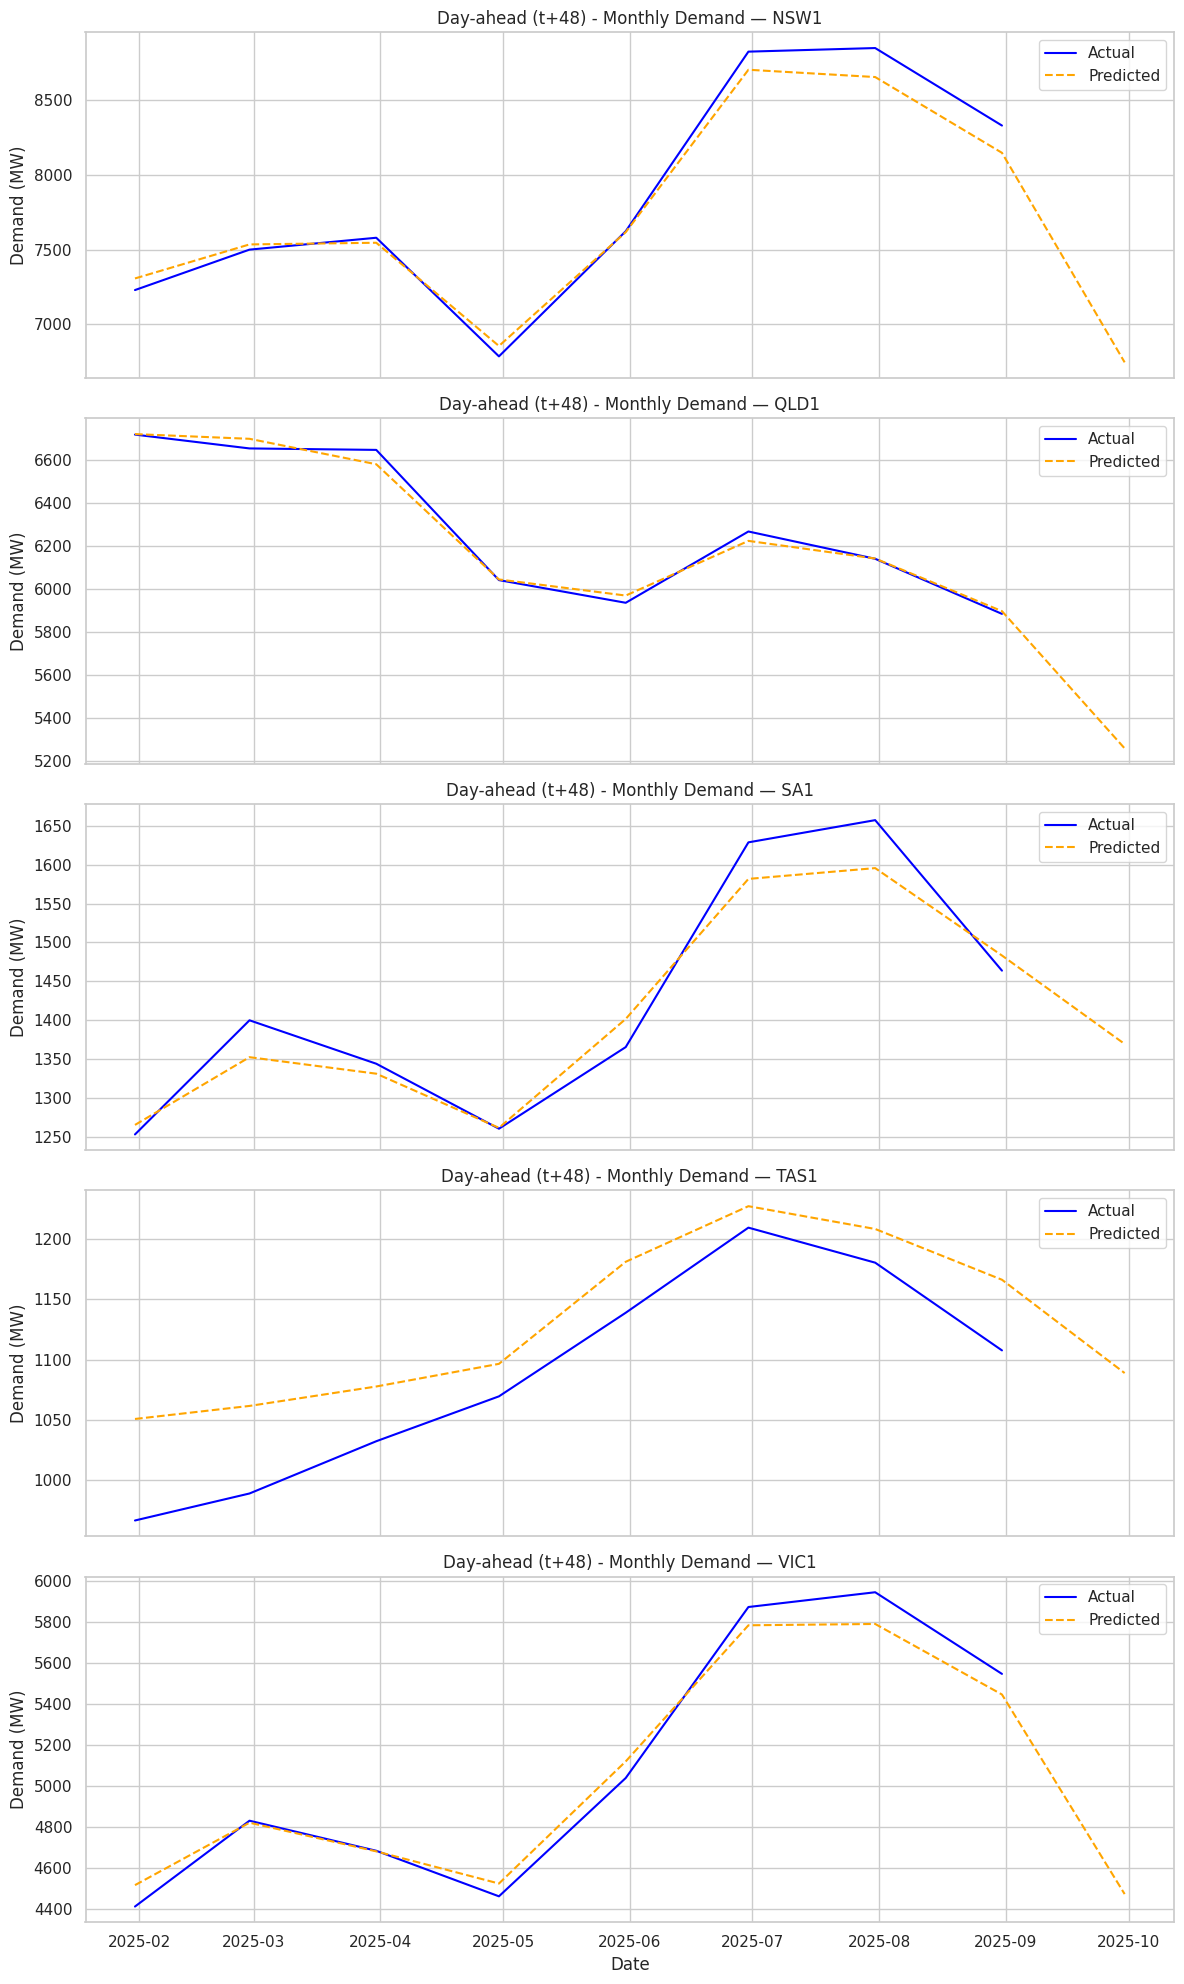


Summary:


label         MAE         RMSE        R2
0  Naive-48  997.388122  1399.771605  0.760440
1    HistGB  280.058435   438.103711  0.976533


  WEEK-AHEAD (T+336) FORECAST — Horizon = 336 half-hours
Train period: (Timestamp('2018-01-01 00:30:00'), Timestamp('2024-12-31 23:55:00'))
Test  period: (Timestamp('2025-01-01 00:00:00'), Timestamp('2025-09-01 00:00:00'))
X_train/X_test: (2026077, 31) (348579, 31)
       Naive-336 -> MAE: 1045.47 | RMSE: 1479.69 | R²: 0.7322
          HistGB -> MAE: 338.30 | RMSE: 526.16 | R²: 0.9661

Per-region (Naive) metrics:
            MAE     RMSE    R2
REGION                        
NSW1    1705.12  2117.41 -0.98
QLD1    1424.19  1732.29 -1.47
SA1      559.50   690.17 -1.35
TAS1     141.95   173.43 -0.60
VIC1    1383.23  1708.66 -0.98

Per-region (HistGB) metrics:
           MAE    RMSE    R2
REGION                      
NSW1    529.86  742.56  0.76
QLD1    341.64  468.44  0.82
SA1     205.34  289.60  0.59
TAS1     94.60  112.37  0.33
VIC1    516.44  715.89  0.65


/tmp/ipython-input-1137291191.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dfm.groupby(region_col, group_keys=False).apply(
/tmp/ipython-input-1137291191.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dfm.groupby(region_col, group_keys=False).apply(


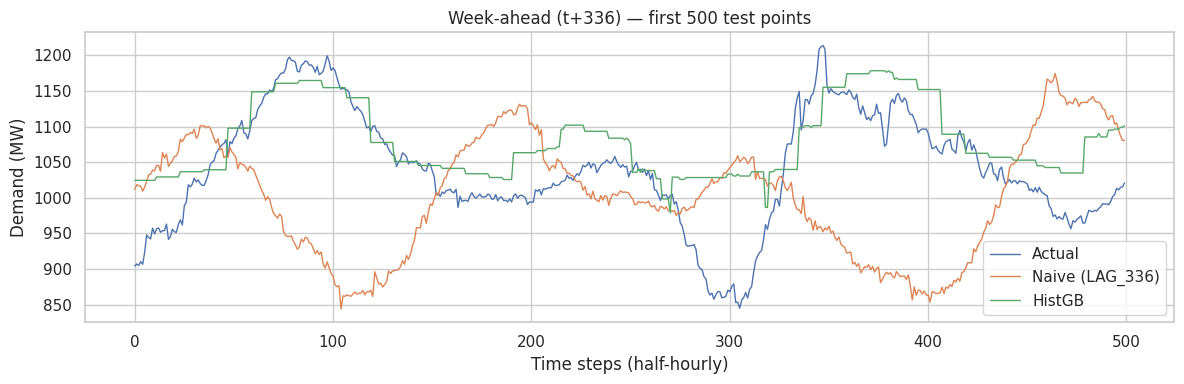

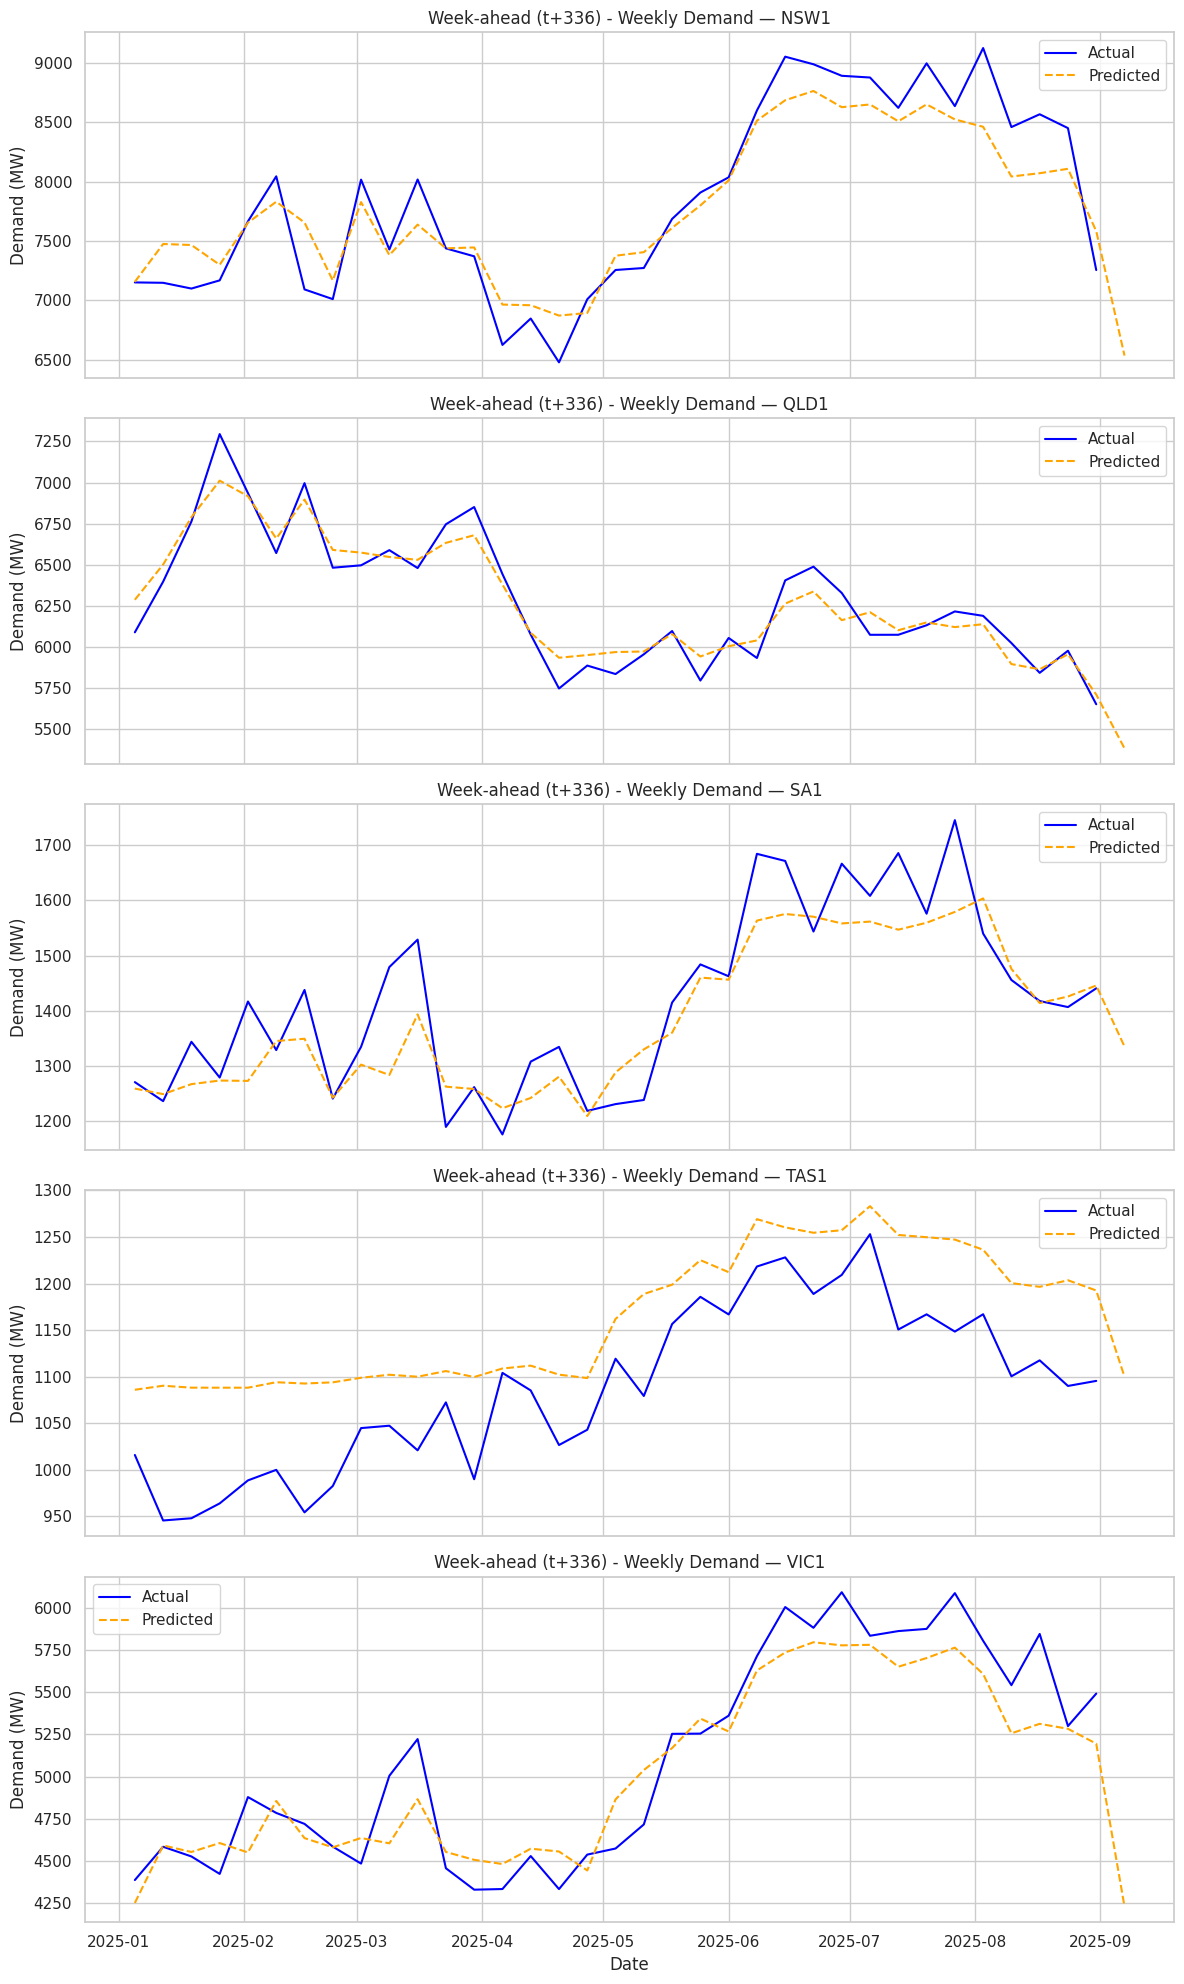

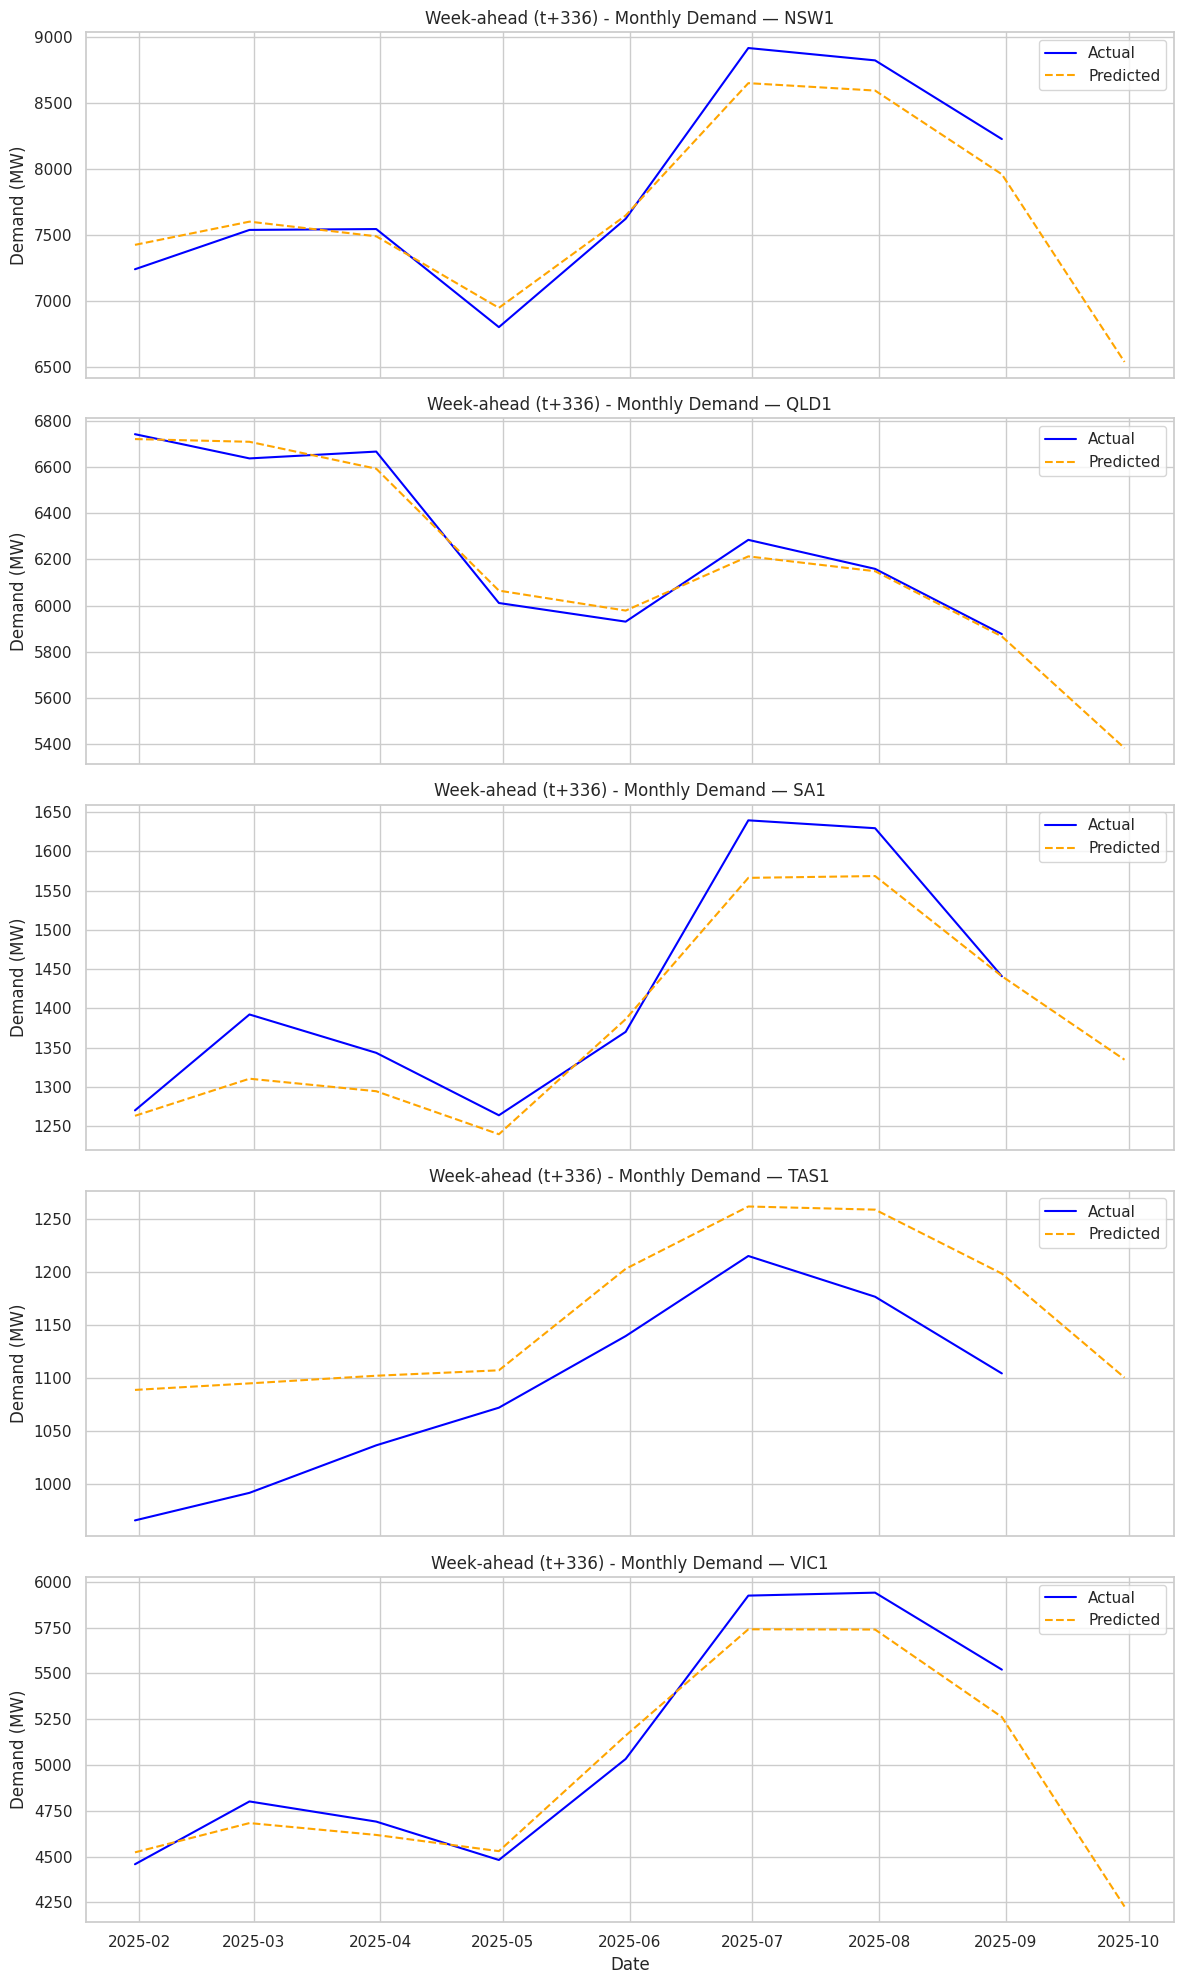


Summary:


label          MAE         RMSE        R2
0  Naive-336  1045.467120  1479.690178  0.732229
1     HistGB   338.298554   526.158882  0.966142

In [33]:
# ============================
# Step 6 — Modeling & Evaluation (Day-ahead & Week-ahead)
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor

def rmse(y_true, y_pred):
    # Calculate the square root of the mean squared error
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate(y_true, y_pred, label):
    m = {
        "label": label,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }
    print(f"{label:>16} -> MAE: {m['MAE']:.2f} | RMSE: {m['RMSE']:.2f} | R²: {m['R2']:.4f}")
    return m

def per_region_metrics(test_df, y_true, y_pred, region_col="REGION"):
    dfm = pd.DataFrame({
        region_col: test_df[region_col].to_numpy(),
        "y": y_true,
        "yhat": y_pred
    })
    # Fix for pandas future deprecation: exclude grouping columns or select explicitly
    return dfm.groupby(region_col, group_keys=False).apply(
        lambda g: pd.Series({
            "MAE": mean_absolute_error(g["y"], g["yhat"]),
            "RMSE": rmse(g["y"], g["yhat"]),
            "R2": r2_score(g["y"], g["yhat"])
        })
    )

def train_hgbr(X_train, y_train, X_test, *, random_state=42):
    # Fast, regularized tree booster with early stopping
    model = HistGradientBoostingRegressor(
        learning_rate=0.06,
        max_depth=None,            # leaf-wise depth is controlled via max_leaf_nodes
        max_leaf_nodes=63,         # small trees generalize well
        min_samples_leaf=256,      # regularization for 2M+ rows
        l2_regularization=0.0,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    return model, yhat

def plot_agg_actual_vs_pred(results_pack, region_col="REGION", freq="W", title="Weekly"):
    """
    Plot aggregated actual vs predicted demand for each region.
    freq = "W" (weekly) or "ME" (monthly end)
    The actual line stops at the last available actual data point.
    """
    test_df = results_pack["test_df"].copy()
    y_true = results_pack["y_true"]
    y_pred = results_pack["y_pred"]

    df_plot = test_df.copy()
    df_plot["Actual"] = y_true
    df_plot["Predicted"] = y_pred

    # Aggregate by region and time
    agg = (
        df_plot.groupby([region_col, pd.Grouper(key="SETTLEMENTDATE", freq=freq)])
        [["Actual", "Predicted"]].mean().reset_index()
    )

    regions = agg[region_col].unique()
    fig, axes = plt.subplots(len(regions), 1, figsize=(12, 4*len(regions)), sharex=True)

    if len(regions) == 1:
        axes = [axes]  # ensure iterable

    # Find the last date with actual data (assuming y_true is aligned with test_df)
    last_actual_date = test_df[~pd.isna(y_true)]['SETTLEMENTDATE'].max()

    for ax, reg in zip(axes, regions):
        df_reg = agg[agg[region_col] == reg]

        # Plot Actual data only up to the last actual date
        df_reg_actual = df_reg[df_reg["SETTLEMENTDATE"] <= last_actual_date]
        ax.plot(df_reg_actual["SETTLEMENTDATE"], df_reg_actual["Actual"], label="Actual", color="blue")

        # Plot Predicted data for the entire period
        ax.plot(df_reg["SETTLEMENTDATE"], df_reg["Predicted"], label="Predicted", color="orange", linestyle='--')

        ax.set_title(f"{title} Demand — {reg}")
        ax.set_ylabel("Demand (MW)")
        ax.legend()

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


def run_pipeline(pack, horizon_name, naive_lag_col):
    print("\n" + "="*72)
    print(f"  {horizon_name.upper()} FORECAST — Horizon = {pack['info']['horizon_hh']} half-hours")
    print("="*72)
    print("Train period:", pack["info"]["train_period"])
    print("Test  period:", pack["info"]["test_period"])
    print("X_train/X_test:", pack["info"]["X_train_shape"], pack["info"]["X_test_shape"])

    # ---------- Baseline (Naïve): use appropriate lag from test_df ----------
    td_test = pack["test_df"].reset_index(drop=True)
    if naive_lag_col not in td_test.columns:
        raise ValueError(f"'{naive_lag_col}' not found in test_df columns.")
    y_true = pack["y_test"]
    y_naive = td_test[naive_lag_col].to_numpy()

    results = []
    results.append(evaluate(y_true, y_naive, label=f"Naive-{naive_lag_col.split('_')[-1]}"))

    # ---------- HistGradientBoosting (fast tree booster) ----------
    model, y_hgbr = train_hgbr(pack["X_train_pre"], pack["y_train"], pack["X_test_pre"])
    results.append(evaluate(y_true, y_hgbr, label="HistGB"))

    # ---------- Per-region metrics ----------
    pr_naive = per_region_metrics(td_test, y_true, y_naive)
    pr_hgbr  = per_region_metrics(td_test, y_true, y_hgbr)

    print("\nPer-region (Naive) metrics:")
    print(pr_naive.round(2))
    print("\nPer-region (HistGB) metrics:")
    print(pr_hgbr.round(2))

    # Store results in the pack for later use
    pack["y_true"] = y_true
    pack["y_pred"] = y_hgbr

    # ---------- Quick preview plot ----------
    N = 500
    plt.figure(figsize=(12,4))
    plt.plot(y_true[:N], label="Actual", linewidth=1)
    plt.plot(y_naive[:N], label=f"Naive ({naive_lag_col})", linewidth=1)
    plt.plot(y_hgbr[:N], label="HistGB", linewidth=1)
    plt.title(f"{horizon_name} — first {N} test points")
    plt.xlabel("Time steps (half-hourly)")
    plt.ylabel("Demand (MW)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Plot aggregated actual vs predicted ----------
    plot_agg_actual_vs_pred(pack, freq="W", title=f"{horizon_name} - Weekly")
    plot_agg_actual_vs_pred(pack, freq="ME", title=f"{horizon_name} - Monthly")


    # ---------- Summary table ----------
    summary = pd.DataFrame(results)
    print("\nSummary:")
    display(summary)

    return {
        "model": model,
        "y_true": y_true,
        "y_naive": y_naive,
        "y_pred": y_hgbr,
        "summary": summary,
        "per_region_naive": pr_naive,
        "per_region_histgb": pr_hgbr
    }

# ============================
# Run for Day-ahead (t+48) and Week-ahead (t+336)
# ============================

day_results  = run_pipeline(day_ahead,  horizon_name="Day-ahead (t+48)",   naive_lag_col="LAG_48")
week_results = run_pipeline(week_ahead, horizon_name="Week-ahead (t+336)", naive_lag_col="LAG_336")

/tmp/ipython-input-414833018.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df_imp.head(top_n), palette="Blues_r")


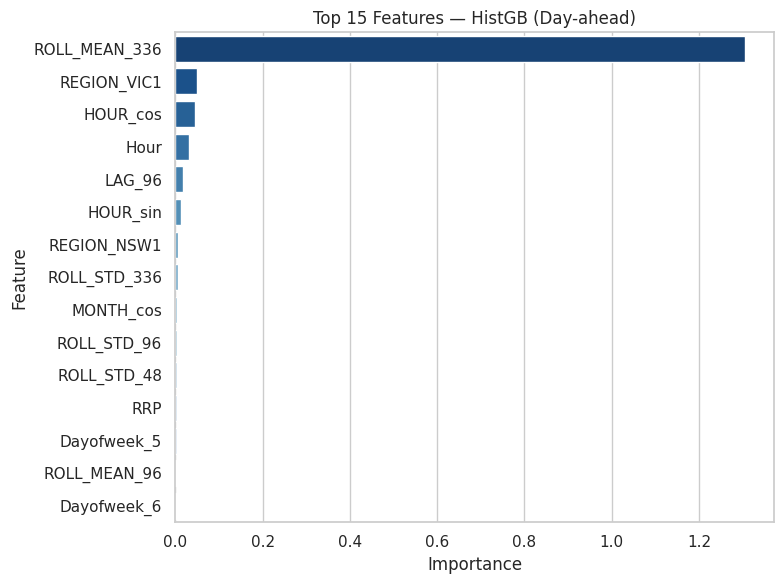

Day-ahead Top 15 Features:
          Feature  Importance
29  ROLL_MEAN_336    1.306635
28    REGION_VIC1    0.048961
27       HOUR_cos    0.046084
26           Hour    0.030295
25         LAG_96    0.017485
24       HOUR_sin    0.012560
23    REGION_NSW1    0.005827
22   ROLL_STD_336    0.005264
21      MONTH_cos    0.004807
20    ROLL_STD_96    0.004413
19    ROLL_STD_48    0.003458
18            RRP    0.002939
17    Dayofweek_5    0.002643
16   ROLL_MEAN_96    0.001795
15    Dayofweek_6    0.001758


/tmp/ipython-input-414833018.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df_imp.head(top_n), palette="Blues_r")


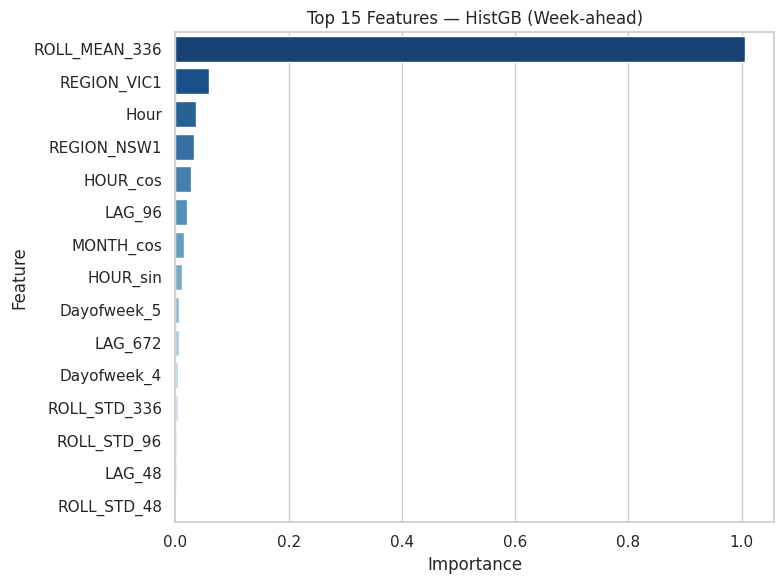


Week-ahead Top 15 Features:
          Feature  Importance
30  ROLL_MEAN_336    1.006975
29    REGION_VIC1    0.059391
28           Hour    0.036400
27    REGION_NSW1    0.033505
26       HOUR_cos    0.026781
25         LAG_96    0.020146
24      MONTH_cos    0.015012
23       HOUR_sin    0.011946
22    Dayofweek_5    0.006802
21        LAG_672    0.006716
20    Dayofweek_4    0.005497
19   ROLL_STD_336    0.005269
18    ROLL_STD_96    0.002833
17         LAG_48    0.002271
16    ROLL_STD_48    0.001402


In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.inspection import permutation_importance
import numpy as np

def plot_feature_importance(model, X_test, y_test, feature_names, model_name, horizon_label, top_n=15):
    """Generate and plot feature importance using permutation importance."""
    # Permutation importance (more reliable for HistGradientBoostingRegressor)
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1) # Use n_jobs=-1 for parallel processing
    sorted_idx = result.importances_mean.argsort()

    df_imp = pd.DataFrame({
        "Feature": np.array(feature_names)[sorted_idx],
        "Importance": result.importances_mean[sorted_idx]
    }).sort_values("Importance", ascending=False)

    # Plot
    plt.figure(figsize=(8,6))
    sns.barplot(x="Importance", y="Feature", data=df_imp.head(top_n), palette="Blues_r")
    plt.title(f"Top {top_n} Features — {model_name} ({horizon_label})")
    plt.tight_layout()
    plt.show()

    # Return table
    return df_imp

# Access models and data from the dictionaries returned by run_pipeline
dayahead_model = day_results['model']
weekahead_model = week_results['model']
X_test_day_pre = day_ahead['X_test_pre']
y_test_day = day_ahead['y_test']
X_test_week_pre = week_ahead['X_test_pre']
y_test_week = week_ahead['y_test']
day_ahead_feature_names = day_ahead['feature_names']
week_ahead_feature_names = week_ahead['feature_names']


# Example: Day-ahead importance using permutation importance
dayahead_imp = plot_feature_importance(dayahead_model, X_test_day_pre, y_test_day, day_ahead_feature_names, "HistGB", "Day-ahead")
print("Day-ahead Top 15 Features:")
print(dayahead_imp.head(15))

# Example: Week-ahead importance using permutation importance
weekahead_imp = plot_feature_importance(weekahead_model, X_test_week_pre, y_test_week, week_ahead_feature_names, "HistGB", "Week-ahead")
print("\nWeek-ahead Top 15 Features:")
print(weekahead_imp.head(15))

In [27]:
# The plotting code has been moved into the run_pipeline function in the cell above.
# This cell is no longer needed.

In [28]:
# Make predictions for the whole test set (which covers 2025)

# Access the trained models and test data
dayahead_model = day_results['model']
weekahead_model = week_results['model']
X_test_day_pre = day_ahead['X_test_pre']
X_test_week_pre = week_ahead['X_test_pre']

# Make predictions
y_pred_dayahead_2025 = dayahead_model.predict(X_test_day_pre)
y_pred_weekahead_2025 = weekahead_model.predict(X_test_week_pre)

print("Predictions for Day-ahead (2025) generated.")
print("Predictions for Week-ahead (2025) generated.")

Predictions for Day-ahead (2025) generated.
Predictions for Week-ahead (2025) generated.


### 6.1 Analyze Residuals

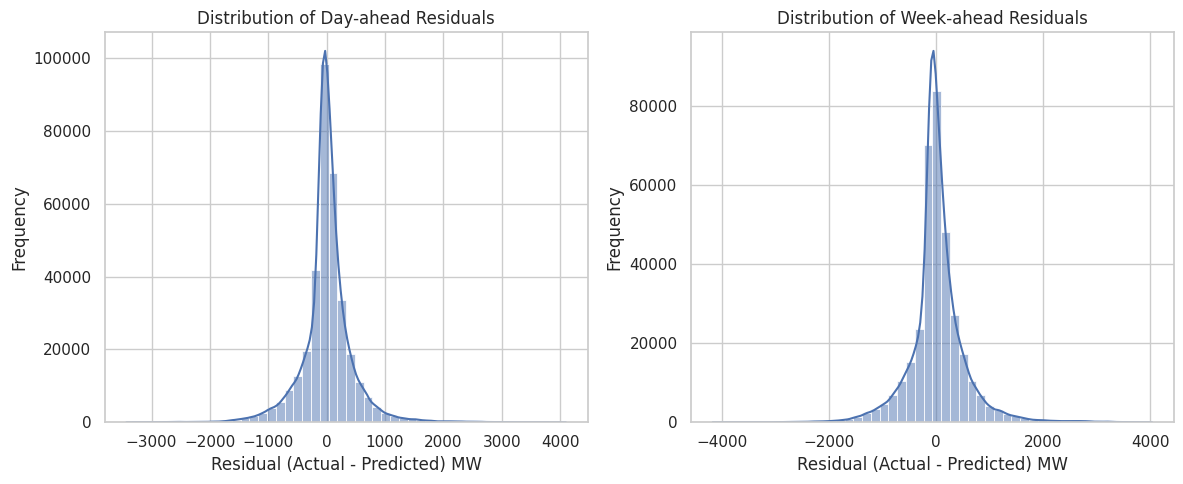

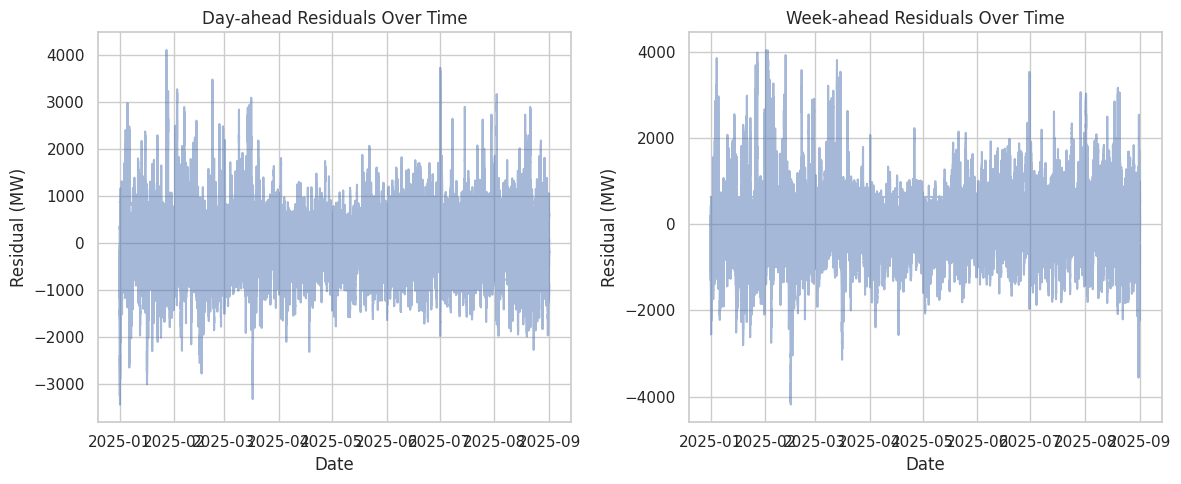

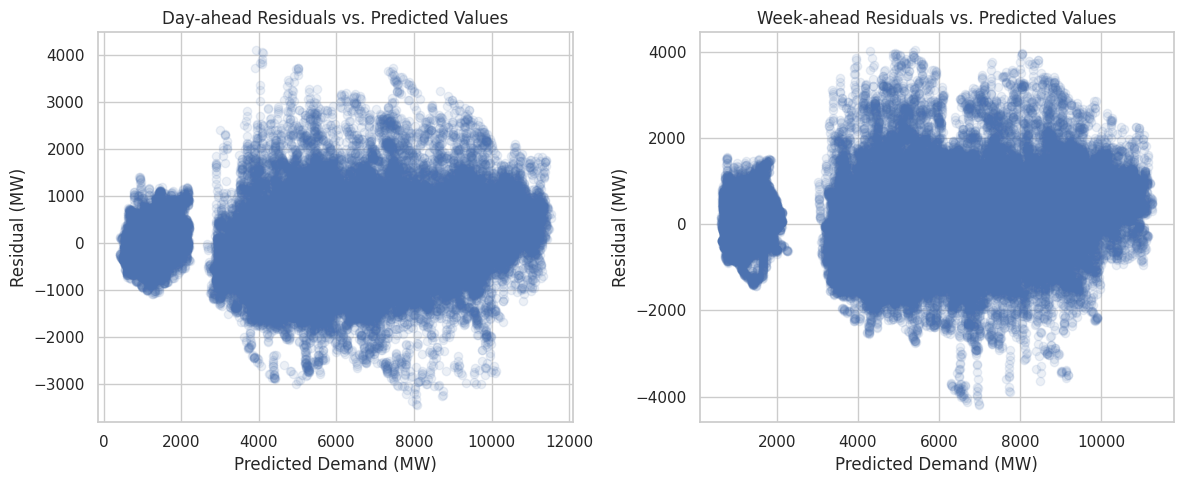

In [29]:
# Access actual values and predictions from the previous steps
y_true_dayahead_2025 = day_results['y_true']
y_pred_dayahead_2025 = day_results['y_pred']
y_true_weekahead_2025 = week_results['y_true']
y_pred_weekahead_2025 = week_results['y_pred']

# Calculate residuals
residuals_dayahead = y_true_dayahead_2025 - y_pred_dayahead_2025
residuals_weekahead = y_true_weekahead_2025 - y_pred_weekahead_2025

# Plot distribution of residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals_dayahead, bins=50, kde=True)
plt.title("Distribution of Day-ahead Residuals")
plt.xlabel("Residual (Actual - Predicted) MW")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(residuals_weekahead, bins=50, kde=True)
plt.title("Distribution of Week-ahead Residuals")
plt.xlabel("Residual (Actual - Predicted) MW")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Plot residuals over time (sample a portion for clarity)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(day_ahead['test_df']['SETTLEMENTDATE'], residuals_dayahead, label='Day-ahead Residuals', alpha=0.5)
plt.title("Day-ahead Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual (MW)")

plt.subplot(1, 2, 2)
plt.plot(week_ahead['test_df']['SETTLEMENTDATE'], residuals_weekahead, label='Week-ahead Residuals', alpha=0.5)
plt.title("Week-ahead Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual (MW)")

plt.tight_layout()
plt.show()

# Plot residuals vs. predicted values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_dayahead_2025, residuals_dayahead, alpha=0.1)
plt.title("Day-ahead Residuals vs. Predicted Values")
plt.xlabel("Predicted Demand (MW)")
plt.ylabel("Residual (MW)")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_weekahead_2025, residuals_weekahead, alpha=0.1)
plt.title("Week-ahead Residuals vs. Predicted Values")
plt.xlabel("Predicted Demand (MW)")
plt.ylabel("Residual (MW)")

plt.tight_layout()
plt.show()

## 7. Summarize Modeling & Evaluation

Based on the modeling and evaluation performed, here's a summary of the results for both the Day-ahead (t+48) and Week-ahead (t+336) electricity demand forecasts using the HistGradientBoostingRegressor model:

### 7.1 Overall Performance Metrics

| Model              | Horizon          | MAE     | RMSE    | R²      |
| :----------------- | :--------------- | :------ | :------ | :------ |
| Naive (LAG_48)     | Day-ahead (t+48) | 997.39  | 1399.77 | 0.7604  |
| HistGB             | Day-ahead (t+48) | 280.06  | 438.10  | 0.9765  |
| Naive (LAG_336)    | Week-ahead (t+336)| 1045.47 | 1479.69 | 0.7322  |
| HistGB             | Week-ahead (t+336)| 338.30  | 526.16  | 0.9661  |

**Insights:**

*   The HistGradientBoostingRegressor model significantly outperforms the Naive baseline for both day-ahead and week-ahead forecasts, as indicated by substantially lower MAE and RMSE values and much higher R² scores.
*   The Day-ahead forecast (Horizon 48) shows better performance metrics (lower MAE/RMSE, higher R²) compared to the Week-ahead forecast (Horizon 336), which is expected as forecasting further into the future is generally more challenging.

### 7.2 Per-Region Performance Metrics

**Day-ahead (t+48) HistGB Metrics:**

| REGION | MAE   | RMSE  | R²   |
| :----- | :---- | :---- | :--- |
| NSW1   | 436.26| 617.24| 0.83 |
| QLD1   | 291.74| 399.76| 0.87 |
| SA1    | 178.75| 249.61| 0.69 |
| TAS1   | 73.77 | 89.44 | 0.58 |
| VIC1   | 418.30| 589.13| 0.77 |

**Week-ahead (t+336) HistGB Metrics:**

| REGION | MAE   | RMSE  | R²   |
| :----- | :---- | :---- | :--- |
| NSW1   | 529.86| 742.56| 0.76 |
| QLD1   | 341.64| 468.44| 0.82 |
| SA1    | 205.34| 289.60| 0.59 |
| TAS1   | 94.60 | 112.37| 0.33 |
| VIC1   | 516.44| 715.89| 0.65 |

**Insights:**

*   The model performs best in terms of absolute error (MAE, RMSE) for the smaller regions (TAS1, SA1), likely due to lower overall demand magnitudes.
*   In terms of R², which measures the proportion of variance explained, the model performs well across most regions for the day-ahead forecast, with QLD1 and NSW1 showing the highest R².
*   For the week-ahead forecast, R² values are generally lower than day-ahead, indicating a decrease in the model's ability to explain variance further out. TAS1 and SA1 show notably lower R² for the week-ahead forecast, suggesting the model struggles more with these regions at a longer horizon.

### 7.3 Feature Importance

The permutation importance analysis revealed the following key features driving the models:

*   **`ROLL_MEAN_336`**: The 1-week rolling mean of total demand is the most important feature for both day-ahead and week-ahead forecasts. This highlights the strong weekly seasonality and the importance of recent average demand in predicting future demand.
*   **Region Encoding (`REGION_VIC1`, `REGION_NSW1`)**: One-hot encoded region features, particularly for VIC1 and NSW1, are highly important. This reflects the significant regional differences in demand patterns and magnitudes.
*   **Time-based Features (`Hour`, `HOUR_cos`, `HOUR_sin`, `MONTH_cos`)**: Features related to the hour of the day and month of the year are crucial, capturing the strong daily and seasonal patterns in electricity demand.
*   **Lagged Demand (`LAG_96`, `LAG_48`, `LAG_672`)**: Demand from previous days (2 days back - LAG_96) and weeks (LAG_672 for week-ahead) are important predictors, confirming the presence of daily and weekly seasonality.
*   **`RRP`**: The real-time price (`RRP`) shows some importance, particularly for the day-ahead forecast, suggesting that current or recent price signals have some predictive power for short-term demand, potentially reflecting price-sensitive demand responses.

### 7.4 Residual Analysis

The residual plots provide further insights:

*   **Distribution of Residuals**: The histograms show that the residuals for both horizons are centered around zero, suggesting the model is not systematically over or under-predicting. However, the distributions show some tails, indicating occasional larger errors. The day-ahead residuals are more tightly distributed around zero than the week-ahead residuals, consistent with the better overall performance.
*   **Residuals Over Time**: The plots of residuals over time show that errors can vary in magnitude and may exhibit some temporal patterns. There might be periods where the model consistently over or under-predicts, potentially linked to specific events or uncaptured external factors.
*   **Residuals vs. Predicted Values**: The scatter plots of residuals against predicted values generally show a fairly uniform spread, suggesting that the model's errors are not strongly dependent on the magnitude of the predicted demand. However, there might be a slight fanning-out effect at higher predicted values, indicating increased variability in errors for higher demand levels.

### 7.5 Conclusion

The HistGradientBoostingRegressor model provides a strong baseline for forecasting electricity demand in the Australian regions. It effectively captures the dominant patterns, particularly weekly seasonality and regional differences. The day-ahead forecasts are significantly more accurate than week-ahead forecasts. Future work could focus on incorporating additional external features (e.g., weather data, event flags) and exploring more advanced time series modeling techniques to potentially reduce residuals further, especially for the week-ahead horizon and during periods of large errors.

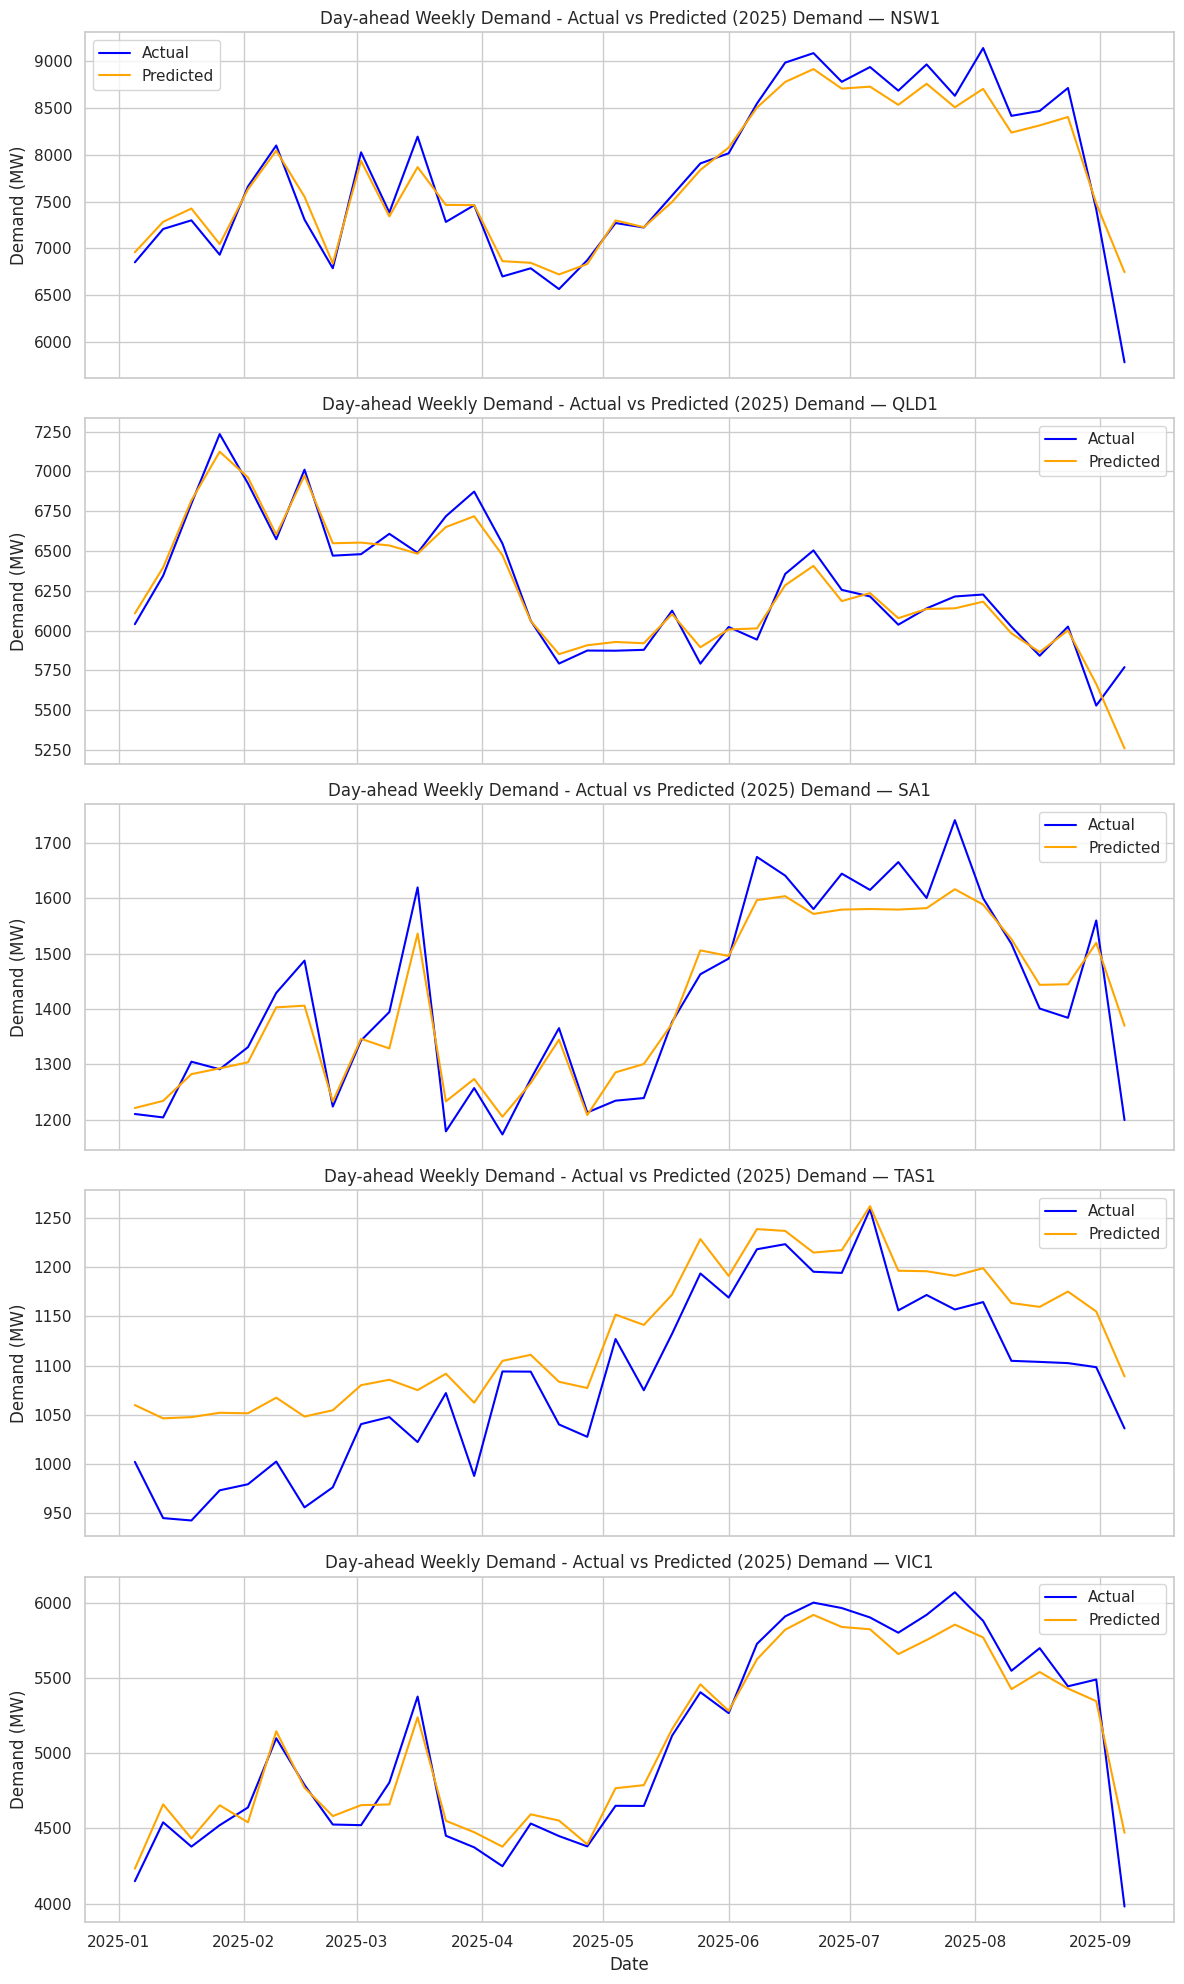

/tmp/ipython-input-1017108745.py:74: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_plot.groupby([region_col, pd.Grouper(key="SETTLEMENTDATE", freq=freq)])


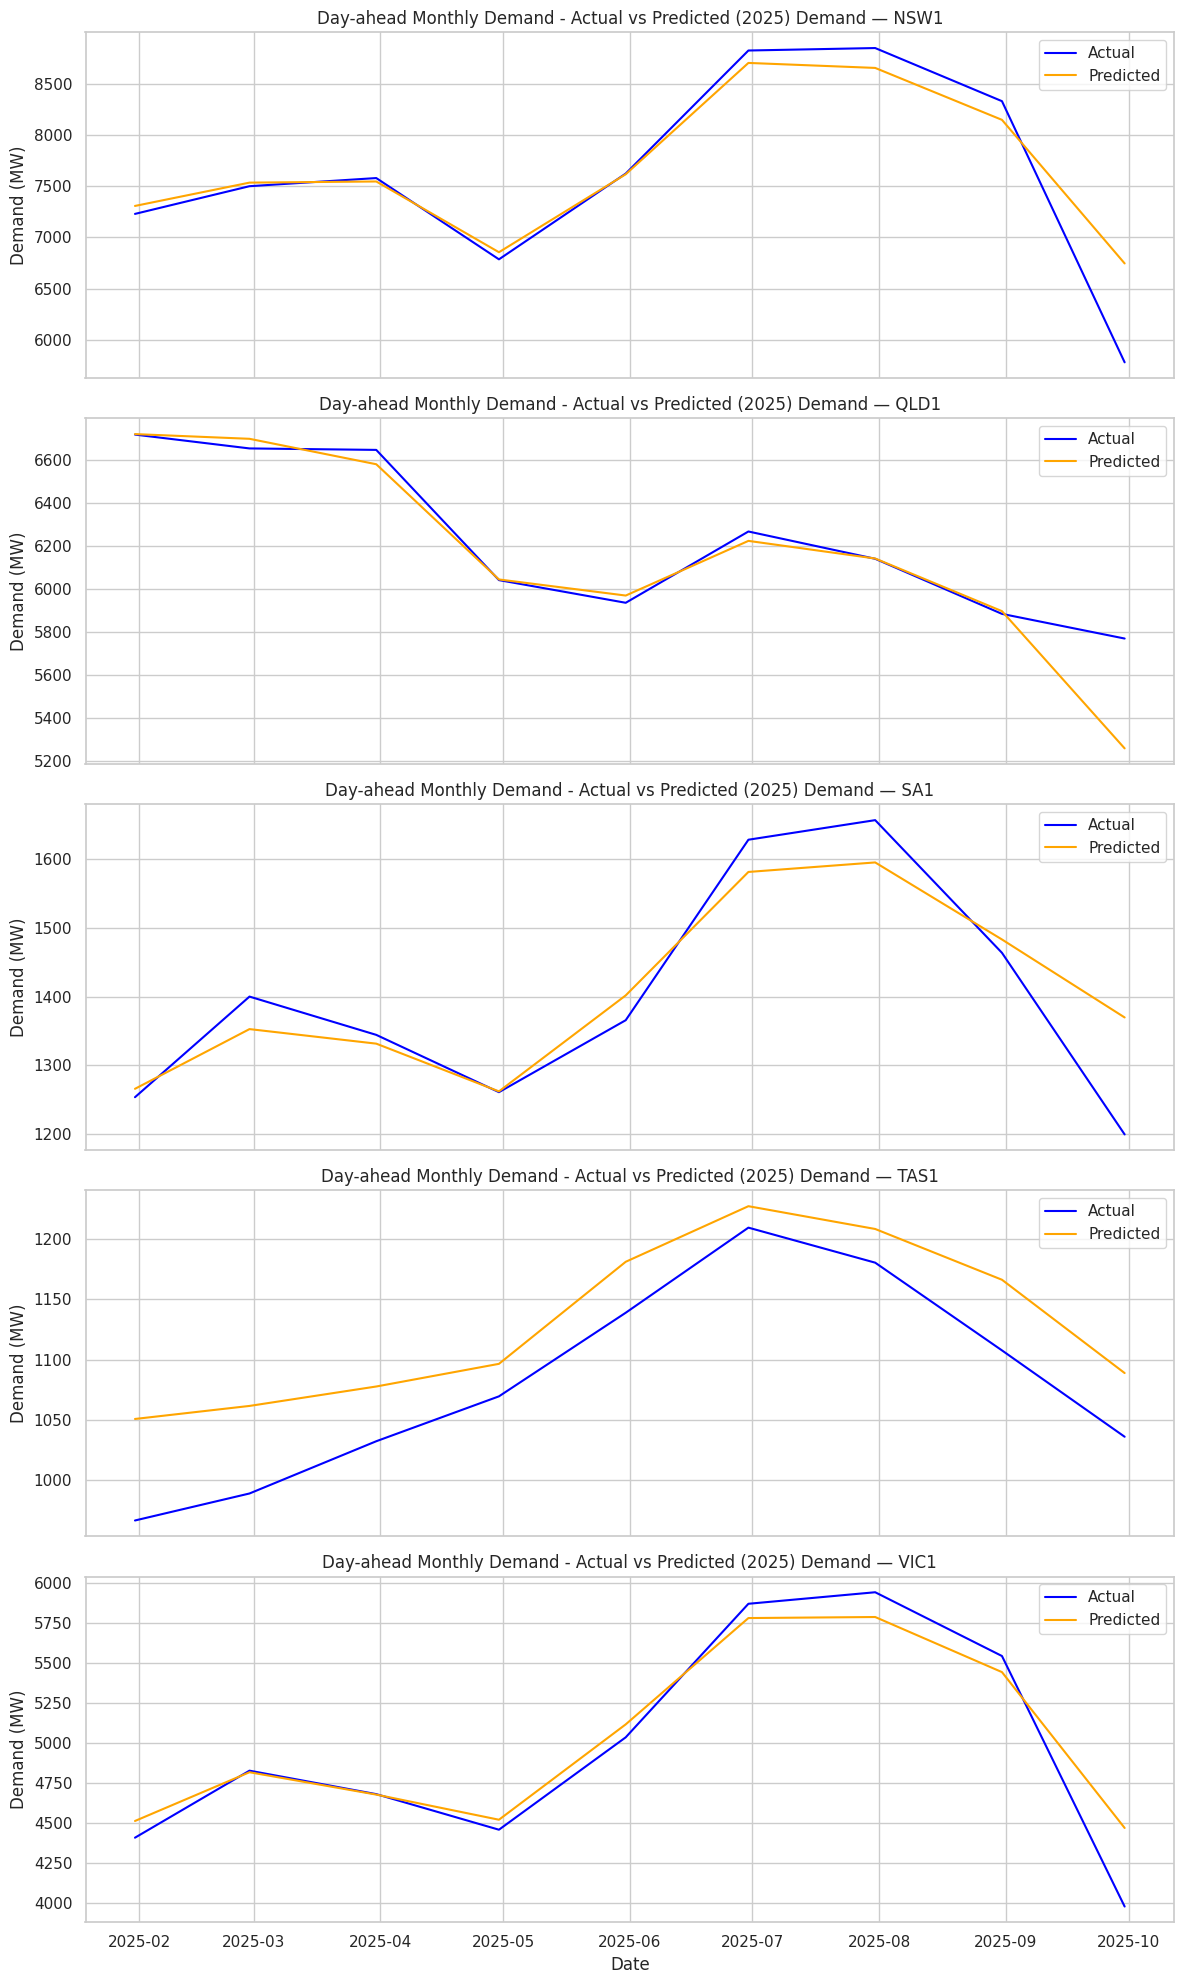

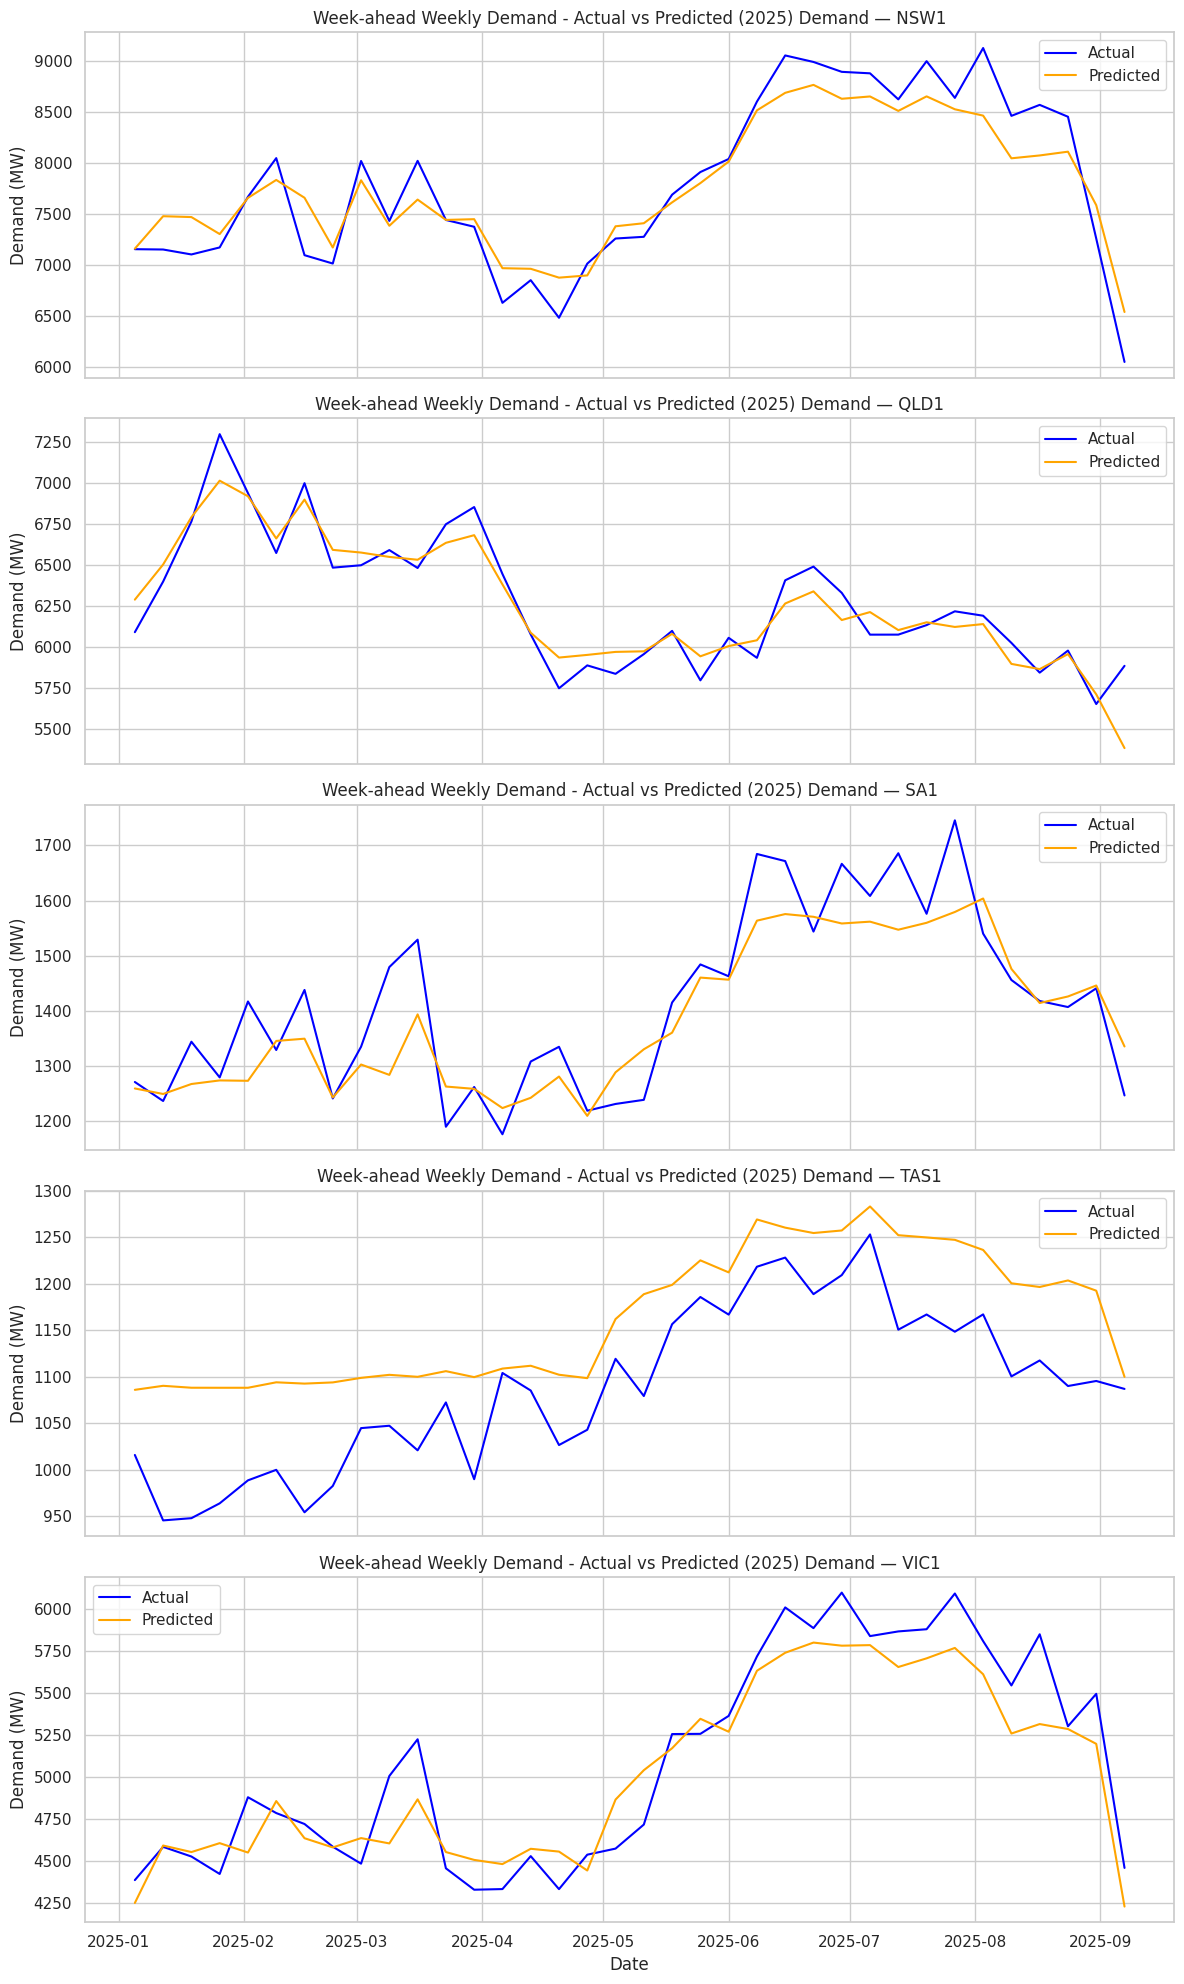

/tmp/ipython-input-1017108745.py:74: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_plot.groupby([region_col, pd.Grouper(key="SETTLEMENTDATE", freq=freq)])


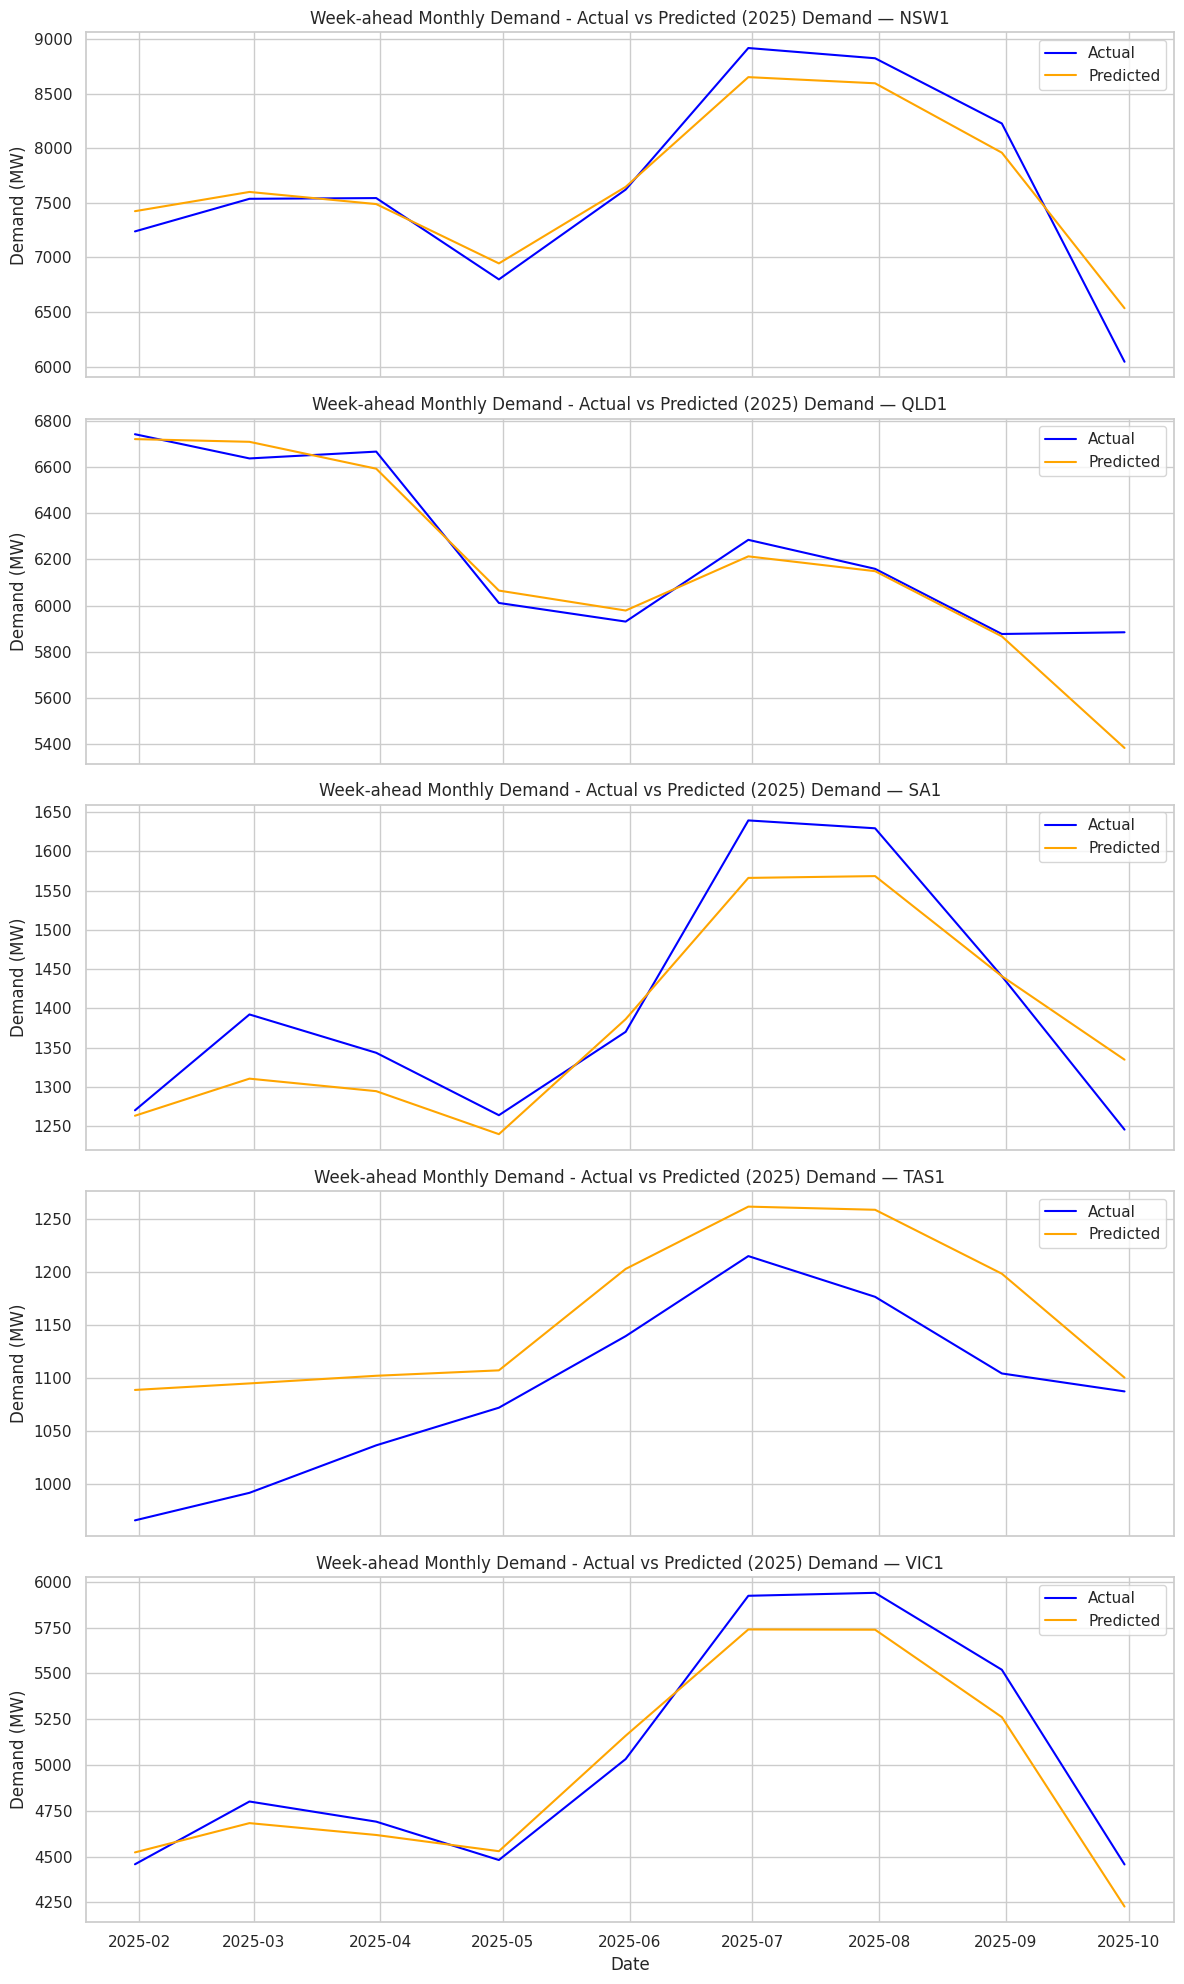

In [30]:
# Plot aggregated actual vs predicted demand for each region for Day-ahead
plot_agg_actual_vs_pred(day_ahead, freq="W", title="Day-ahead Weekly Demand - Actual vs Predicted (2025)")
plot_agg_actual_vs_pred(day_ahead, freq="M", title="Day-ahead Monthly Demand - Actual vs Predicted (2025)")

# Plot aggregated actual vs predicted demand for each region for Week-ahead
plot_agg_actual_vs_pred(week_ahead, freq="W", title="Week-ahead Weekly Demand - Actual vs Predicted (2025)")
plot_agg_actual_vs_pred(week_ahead, freq="M", title="Week-ahead Monthly Demand - Actual vs Predicted (2025)")

In [35]:
import joblib
import os

# Define the path in Google Drive where you want to save the models
# Ensure this directory exists
model_save_path = '/content/drive/MyDrive/Sem2_2025 Spring/36103 Statistical Thinking for Data Science - Spring 2025/stats_assignments/stats_at2/Models'
os.makedirs(model_save_path, exist_ok=True)

# Access the trained models from the results dictionaries
dayahead_model = day_results['model']
weekahead_model = week_results['model']

# Define filenames for the models
dayahead_model_filename = os.path.join(model_save_path, 'dayahead_demand_model.pkl')
weekahead_model_filename = os.path.join(model_save_path, 'weekahead_demand_model.pkl')

# Save the models
joblib.dump(dayahead_model, dayahead_model_filename)
joblib.dump(weekahead_model, weekahead_model_filename)

print(f"Day-ahead model saved to: {dayahead_model_filename}")
print(f"Week-ahead model saved to: {weekahead_model_filename}")

Day-ahead model saved to: /content/drive/MyDrive/Sem2_2025 Spring/36103 Statistical Thinking for Data Science - Spring 2025/stats_assignments/stats_at2/Models/dayahead_demand_model.pkl
Week-ahead model saved to: /content/drive/MyDrive/Sem2_2025 Spring/36103 Statistical Thinking for Data Science - Spring 2025/stats_assignments/stats_at2/Models/weekahead_demand_model.pkl
